In [1]:
import tensorflow as tf

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices) > 0:
    for gpu in gpu_devices:
        tf.config.experimental.set_memory_growth(gpu, True)
    print('GPU is available')
else:
    print('GPU is not available')

# 打印TensorFlow版本和GPU信息
print('TensorFlow version:', tf.__version__)
print('GPU info:', tf.config.list_physical_devices('GPU'))

GPU is available
TensorFlow version: 2.5.0
GPU info: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from deeptables.models import deeptable, deepnets
from deeptables.datasets import dsutils
from sklearn.model_selection import train_test_split
import deeptables.datasets as dt_datasets
from deeptables.models.deeptable import DeepTable, ModelConfig
from tensorflow import keras

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn.metrics import classification_report

F:\anaconda3\envs\dxtf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
F:\anaconda3\envs\dxtf\lib\site-packages\woodwork\__init__.py:23: FutureWarning: Woodwork may not support Python 3.7 in next non-bugfix release.
  "Woodwork may not support Python 3.7 in next non-bugfix release.", FutureWarning
F:\anaconda3\envs\dxtf\lib\site-packages\featuretools\__init__.py:67: FutureWarning: Featuretools may not support Python 3.7 in next non-bugfix release.
  FutureWarning,


In [3]:
data0 = pd.read_csv("D:/Download/Android_Malware.csv")

F:\anaconda3\envs\dxtf\lib\site-packages\IPython\core\interactiveshell.py:3553: DtypeWarning: Columns (56,58,63) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
data0.head()
data0.columns = [col[1:] if col.startswith(' ') else col for col in data0.columns]

In [5]:
data0=data0.dropna()
data0=data0.drop('Unnamed: 0',axis=1)

In [6]:
label_counts = data0['Label'].value_counts().rename_axis('Label').reset_index(name='Counts')
label_percentages = data0['Label'].value_counts(normalize=True).rename_axis('Label').reset_index(name='Percentage')

result = pd.merge(label_counts, label_percentages, on='Label')
result['Percentage'] = result['Percentage'] * 100

print("Label Counts and Percentages:\n")
print(result)

names = sorted(data0['Label'].unique().tolist())
print("\nLabels:", names)

Label Counts and Percentages:

                 Label  Counts  Percentage
0       Android_Adware  147443   41.460129
1    Android_Scareware  117081   32.922508
2  Android_SMS_Malware   67394   18.950808
3               Benign   23708    6.666554

Labels: ['Android_Adware', 'Android_SMS_Malware', 'Android_Scareware', 'Benign']


In [7]:
N=list(range(len(names)))
normal_mapping=dict(zip(names,N)) 
reverse_mapping=dict(zip(N,names))       
data0['Label']=data0['Label'].map(normal_mapping)

data0['Down/Up Ratio']=data0['Down/Up Ratio'].apply(lambda x:int(x))
data0=data0.drop('Timestamp',axis=1)
data0=data0.drop('CWE Flag Count',axis=1)
data0=data0.drop('Fwd Avg Bytes/Bulk',axis=1)

In [8]:
def labelencoder(df):
    for c in df.columns:
        #print(c)
        if df[c].dtype=='object': 
            #df[c] = df[c].fillna('missing')
            df[c] = df[c].fillna('N')
            lbl = LabelEncoder()
            lbl.fit(list(df[c].values))
            df[c] = lbl.transform(df[c].values)
    return df

data0=labelencoder(data0)

In [9]:
data0=data0.drop('Flow ID',axis=1)
# data0=data0.drop('Source IP',axis=1)
# data0=data0.drop('Destination IP',axis=1)
# data0=data0.drop('Source Port',axis=1)
# data0=data0.drop('Destination Port',axis=1)
dataY=data0['Label']
dataX=data0.drop(['Label'],axis=1)

In [10]:
# from sklearn.ensemble import IsolationForest
# clf = IsolationForest(random_state=42, contamination='auto')
# clf.fit(data0)
# outliers = clf.predict(data0) == -1
# plt.figure(figsize=(20, 20))
# sns.boxplot(data=data0)
# plt.title('Boxplot of Data')
# plt.show()
# print('离群点数:', np.sum(outliers))
# print('数据集中有{}个数据点。'.format(len(data0)))
# data0 = data0[~outliers]
# print('删除离群点后，数据集中剩余{}个数据点。'.format(len(data0)))

In [11]:
# plt.figure(figsize=(20, 20))
# sns.boxplot(data=data0)
# plt.title('Boxplot of Data')
# plt.show()

In [12]:
label_counts = data0['Label'].value_counts().rename_axis('Label').reset_index(name='Counts')
label_percentages = data0['Label'].value_counts(normalize=True).rename_axis('Label').reset_index(name='Percentage')

result = pd.merge(label_counts, label_percentages, on='Label')
result['Percentage'] = result['Percentage'] * 100

print("Label Counts and Percentages:\n")
print(result)

names2 = sorted(data0['Label'].unique().tolist())
print("\nLabels:", names2)


# Label Counts and Percentages:

#                  Label  Counts  Percentage
# 0       Android_Adware  147443   41.460129
# 1    Android_Scareware  117081   32.922508
# 2  Android_SMS_Malware   67394   18.950808
# 3               Benign   23708    6.666554

Label Counts and Percentages:

   Label  Counts  Percentage
0      0  147443   41.460129
1      2  117081   32.922508
2      1   67394   18.950808
3      3   23708    6.666554

Labels: [0, 1, 2, 3]


In [13]:
dataY=data0['Label']
dataX=data0.drop(['Label'],axis=1)
all_columns = list(dataX.columns)
dataX

,Source IP,Source Port,Destination IP,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,9,50004,1283,443.0,6.0,37027,1,1,0.0,0.0,...,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9,35455,1283,443.0,6.0,36653,1,1,0.0,0.0,...,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9,51775,648,443.0,6.0,534099,8,12,1011.0,11924.0,...,3.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9,51775,648,443.0,6.0,9309,3,0,0.0,0.0,...,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9,51776,648,443.0,6.0,19890496,8,6,430.0,5679.0,...,2.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355625,717,80,17,38405.0,6.0,126711,1,1,0.0,0.0,...,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
355626,9,7632,15,53.0,17.0,48012,1,1,30.0,140.0,...,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
355627,9,45970,99,443.0,6.0,20028018,11,8,339.0,6335.0,...,2.0,20.0,367528.0,0.0,367528.0,367528.0,19660490.0,0.0,19660490.0,19660490.0
355628,9,51982,15,53.0,17.0,347926,1,1,32.0,48.0,...,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
dataX_std = scaler.fit_transform(dataX)
dataX = pd.DataFrame(dataX_std, columns=dataX.columns)

In [15]:
dataX

,Source IP,Source Port,Destination IP,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,-0.270776,0.608170,0.041928,-0.331393,-0.511329,-0.499473,-0.094880,-0.049534,-0.034977,-0.040864,...,-0.102047,0.005114,-0.184644,-0.07675,-0.181619,-0.172910,-0.279270,-0.110393,-0.284337,-0.268581
1,-0.270776,-0.206160,0.041928,-0.331393,-0.511329,-0.499490,-0.094880,-0.049534,-0.034977,-0.040864,...,-0.102047,0.005114,-0.184644,-0.07675,-0.181619,-0.172910,-0.279270,-0.110393,-0.284337,-0.268581
2,-0.270776,0.707296,-0.445489,-0.331393,-0.511329,-0.476680,0.009590,0.007854,0.017087,0.002279,...,0.098779,0.005112,-0.184644,-0.07675,-0.181619,-0.172910,-0.279270,-0.110393,-0.284337,-0.268581
3,-0.270776,0.707296,-0.445489,-0.331393,-0.511329,-0.500744,-0.065031,-0.054751,-0.034977,-0.040864,...,-0.102047,0.005112,-0.184644,-0.07675,-0.181619,-0.172910,-0.279270,-0.110393,-0.284337,-0.268581
4,-0.270776,0.707352,-0.445489,-0.331393,-0.511329,0.410875,0.009590,-0.023449,-0.012833,-0.020316,...,0.031837,0.005112,-0.184644,-0.07675,-0.181619,-0.172910,-0.279270,-0.110393,-0.284337,-0.268581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355621,1.475602,-2.186156,-0.929835,2.313878,-0.511329,-0.495361,-0.094880,-0.049534,-0.034977,-0.040864,...,-0.102047,0.005114,-0.184644,-0.07675,-0.181619,-0.172910,-0.279270,-0.110393,-0.284337,-0.268581
355622,-0.270776,-1.763458,-0.931370,-0.358569,1.897171,-0.498969,-0.094880,-0.049534,-0.033432,-0.040357,...,-0.102047,0.005114,-0.184644,-0.07675,-0.181619,-0.172910,-0.279270,-0.110393,-0.284337,-0.268581
355623,-0.270776,0.382381,-0.866893,-0.331393,-0.511329,0.417180,0.054363,-0.013014,-0.017519,-0.017943,...,0.031837,0.005112,0.232161,-0.07675,0.178888,0.263395,1.084606,-0.110393,1.014238,1.128714
355624,-0.270776,0.718882,-0.931370,-0.358569,1.897171,-0.485217,-0.094880,-0.049534,-0.033329,-0.040690,...,-0.102047,0.005112,-0.184644,-0.07675,-0.181619,-0.172910,-0.279270,-0.110393,-0.284337,-0.268581


In [16]:
categorical_columns = ['Protocol','Fwd PSH Flags','Source IP','Destination IP','Source Port','Destination Port',
                       'Bwd PSH Flags','Fwd URG Flags','Bwd URG Flags']
# categorical_columns = ['Protocol','Fwd PSH Flags', 'Bwd PSH Flags','Fwd URG Flags','Bwd URG Flags']
numerical_columns = [col for col in all_columns if col not in categorical_columns]
numerical_columns = numerical_columns[:-1]
print(numerical_columns)

['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'ECE Flag Count', 'Down/Up Ratio', 'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Fwd Header Len

In [17]:
x_train, x_val, y_train, y_val = train_test_split(dataX, dataY, test_size=0.2, stratify=dataY, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, stratify=y_val, random_state=42)

In [18]:
epochs = 200
batch_size=1024
counts = dataY.value_counts()
print(counts)
class_weight = {i: max(counts) / counts[i] for i in range(len(counts))}
print(class_weight)

0    147443
2    117081
1     67394
3     23708
Name: Label, dtype: int64
{0: 1.0, 1: 2.1877763599133453, 2: 1.2593247409912796, 3: 6.219124346212249}


In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

In [20]:
print("Accuracy:", rf.score(x_test, y_test))
print('============val_data===================')
t_names = [str(name) for name in names]
print(classification_report(y_test, y_pred, target_names=t_names, digits=4))

Accuracy: 0.61246239068695
============val_data===================
                     precision    recall  f1-score   support

     Android_Adware     0.6584    0.7594    0.7053     14745
Android_SMS_Malware     0.6539    0.5263    0.5832      6739
  Android_Scareware     0.5417    0.5669    0.5540     11708
             Benign     0.4540    0.1687    0.2460      2371

           accuracy                         0.6125     35563
          macro avg     0.5770    0.5053    0.5221     35563
       weighted avg     0.6055    0.6125    0.6017     35563



In [101]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
class_counts = np.bincount(y_train)
class_weights = np.sum(class_counts) / (len(class_counts) * class_counts)
sample_weights = class_weights[y_train]
adaboost = AdaBoostClassifier()
adaboost = AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
adaboost.fit(x_train, y_train,sample_weight=sample_weights)

print("Accuracy:", adaboost.score(x_test, y_test))
print('============val_data===================')
t_names = [str(name) for name in names]
print(classification_report(y_test, y_pred, target_names=t_names, digits=4))

Accuracy: 0.43702724742007143
============val_data===================
                     precision    recall  f1-score   support

     Android_Adware     0.4889    0.7428    0.5896     14745
Android_SMS_Malware     0.8214    0.2211    0.3484      6739
  Android_Scareware     0.4030    0.3906    0.3967     11708
             Benign     0.0000    0.0000    0.0000      2371

           accuracy                         0.4784     35563
          macro avg     0.4283    0.3386    0.3337     35563
       weighted avg     0.4910    0.4784    0.4411     35563



F:\anaconda3\envs\dxtf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\anaconda3\envs\dxtf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\anaconda3\envs\dxtf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
config = ModelConfig(
    nets=['dnn_nets'],
    categorical_columns=categorical_columns,
#     apply_gbm_features=True,
#     auto_discrete=True,
#     auto_categorize=True,
#     cat_exponent=0.7,
    metrics=[ 'accuracy','AUC'],
    pnn_params={
        'outer_product_kernel_type': 'mat',
    },
    afm_params={
        'attention_factor': 5,
        'dropout_rate': 0.3,
    },
    fgcnn_params={
        'fg_filters': (14, 16),
        'fg_widths': (7, 7),
        'fg_pool_widths': (2, 2),
        'fg_new_feat_filters': (2, 2),
    },
    fibinet_params={
        'senet_pooling_op': 'mean',
        'senet_reduction_ratio': 3,
        'bilinear_type': 'field_interaction',
    },
    cross_params={
        'num_cross_layer': 10,
    },
    autoint_params={
        'num_attention': 5,
        'num_heads': 1,
        'dropout_rate': 0.2,
        'use_residual': True,
    },
    apply_class_weight=True,
    stacking_op='concat',
    dnn_params={
        'hidden_units':((128, 0.2, False),(128, 0.2, False),(128, 0.2, False),(128, 0.2, False),(128, 0.2, False),
                       ),
        'activation': 'relu',
    },
    cin_params={
        'cross_layer_size': (128, 128),
        'activation': 'relu',
        'use_residual': True,
        'use_bias': False,
        'direct': True,
        'reduce_D': True,
    },
    earlystopping_patience=5,
    embeddings_output_dim=100,
    embedding_dropout=0,
    dense_dropout=0.2,
    home_dir='E:/temp',
#     embeddings_initializer='he_uniform',
#     optimizer='Adagrad',
#     embeddings_regularizer='l2',
    
)

dt = deeptable.DeepTable(config=config)

In [21]:
model, history = dt.fit(x_train, y_train, epochs=epochs, validation_data=(x_val, y_val),class_weight=class_weight,
                        batch_size=batch_size, max_queue_size=10, workers=4, use_multiprocessing=False)

04-27 17:08:50 I deeptables.m.deeptable.py 338 - X.Shape=(284500, 80), y.Shape=(284500,), batch_size=1024, config=ModelConfig(name='conf-1', nets=['dnn_nets'], categorical_columns=['Protocol', 'Fwd PSH Flags', 'Source IP', 'Destination IP', 'Source Port', 'Destination Port', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags'], exclude_columns=[], task='auto', pos_label=None, metrics=['accuracy', 'AUC'], auto_categorize=False, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=False, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, embeddings_output_dim=100, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0.2, embedding_dropout=0, stacking_op='concat', output_use_bias=True, apply_class_weight=True, optimizer='auto', loss='auto', dnn_params={'hidden_units': ((128, 0.2, False), (128, 0.2, False), (12

277/277 [==============================] - 10s 36ms/step - loss: 0.2199 - accuracy: 0.9291 - auc: 0.9953 - val_loss: 1.5100 - val_accuracy: 0.7122 - val_auc: 0.8854
Epoch 18/200
277/277 [==============================] - 10s 36ms/step - loss: 0.2164 - accuracy: 0.9297 - auc: 0.9954 - val_loss: 1.5612 - val_accuracy: 0.7145 - val_auc: 0.8833
Epoch 19/200
277/277 [==============================] - 10s 36ms/step - loss: 0.2058 - accuracy: 0.9318 - auc: 0.9958 - val_loss: 1.6140 - val_accuracy: 0.7122 - val_auc: 0.8832
Epoch 20/200
277/277 [==============================] - 10s 36ms/step - loss: 0.2052 - accuracy: 0.9324 - auc: 0.9959 - val_loss: 1.6288 - val_accuracy: 0.7172 - val_auc: 0.8831
Epoch 21/200
277/277 [==============================] - 10s 36ms/step - loss: 0.2005 - accuracy: 0.9339 - auc: 0.9960 - val_loss: 1.5857 - val_accuracy: 0.7111 - val_auc: 0.8823
Epoch 22/200
277/277 [==============================] - 10s 36ms/step - loss: 0.1964 - accuracy: 0.9343 - auc: 0.9962 - val

In [22]:
#evaluation
result = dt.evaluate(x_test,y_test)
print(result)

#scoring
preds = dt.predict(x_test)

04-27 17:13:22 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-27 17:13:22 I deeptables.m.preprocessor.py 249 - transform_X taken 0.13115549087524414s
04-27 17:13:22 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-27 17:13:22 I deeptables.m.preprocessor.py 236 - transform_y taken 0.000997304916381836s
04-27 17:13:22 I deeptables.m.deepmodel.py 158 - Performing evaluation...
04-27 17:13:22 I deeptables.u.dataset_generator.py 240 - create dataset generator with _TFDGForPandas, batch_size=256, shuffle=False, drop_remainder=False
{'loss': 1.6330766677856445, 'accuracy': 0.7170935869216919, 'auc': 0.8837042450904846}
04-27 17:13:23 I deeptables.m.deeptable.py 685 - Perform prediction...
04-27 17:13:23 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-27 17:13:23 I deeptables.m.preprocessor.py 249 - transform_X taken 0.1301577091217041s
04-27 17:13:23 I deeptables.m.deepmodel.py 130 - Performing predictions...
04-27 17:13:23 I deeptables.u.dataset_generator.py 240 - 

In [23]:
print(result)
print('============val_data===================')
print(classification_report(y_test, preds, target_names=names, digits=4))

{'loss': 1.6330766677856445, 'accuracy': 0.7170935869216919, 'auc': 0.8837042450904846}
============val_data===================
                     precision    recall  f1-score   support

     Android_Adware     0.7820    0.7703    0.7761     14745
Android_SMS_Malware     0.6765    0.7558    0.7139      6739
  Android_Scareware     0.7175    0.6520    0.6832     11708
             Benign     0.4939    0.5976    0.5408      2371

           accuracy                         0.7171     35563
          macro avg     0.6674    0.6939    0.6785     35563
       weighted avg     0.7215    0.7171    0.7180     35563



In [75]:
config = ModelConfig(
    nets=['dnn_nets'],
    dnn_params={
#         'hidden_units': ((64, 0.2, True), (40, 0.2, True),(32, 0.2, True),(20, 0.2, True),(16, 0.2, True),(8, 0.2, True)),
        'hidden_units':((300, 0.3, True),(300, 0.3, True)),
        'activation': 'relu',
    },
    apply_gbm_features=True,
    categorical_columns=categorical_columns,
    auto_discrete=True,
#     auto_categorize=True,
    metrics=['AUC'],
    earlystopping_patience=5,
    embeddings_output_dim=100,
    embedding_dropout=0.3,
    optimizer='Adam',
    stacking_op='add',
    apply_class_weight=True,
    embeddings_regularizer='l2',

)

dt = deeptable.DeepTable(config=config)

In [31]:
model, history = dt.fit(x_train, y_train, epochs=epochs, validation_data=(x_val, y_val),class_weight=class_weight,
                        batch_size=batch_size,  max_queue_size=10, workers=4, use_multiprocessing=True,)

04-25 18:48:18 I deeptables.m.deeptable.py 338 - X.Shape=(284500, 80), y.Shape=(284500,), batch_size=1024, config=ModelConfig(name='conf-1', nets=['dnn_nets', 'linear', 'autoint_nets'], categorical_columns=['Protocol', 'Fwd PSH Flags', 'Source IP', 'Destination IP', 'Source Port', 'Destination Port', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags'], exclude_columns=[], task='auto', pos_label=None, metrics=['AUC'], auto_categorize=False, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=True, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, embeddings_output_dim=100, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0, embedding_dropout=0.3, stacking_op='add', output_use_bias=True, apply_class_weight=True, optimizer='Adam', loss='auto', dnn_params={'hidden_units': ((300, 0.3, True), (300, 0.3, Tru

F:\anaconda3\envs\dxtf\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
F:\anaconda3\envs\dxtf\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
F:\anaconda3\envs\dxtf\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
F:\anaconda3\envs\dxtf\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of 

F:\anaconda3\envs\dxtf\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
F:\anaconda3\envs\dxtf\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
F:\anaconda3\envs\dxtf\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
F:\anaconda3\envs\dxtf\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of 

04-25 18:48:22 I deeptables.m.preprocessor.py 404 - Discretization taken 2.2286579608917236s
04-25 18:48:22 I deeptables.m.preprocessor.py 423 - Extracting GBM features...
04-25 18:48:22 I hypernets.t.sklearn_ex.py 640 - LightGBM task:multiclass
04-25 18:48:27 I deeptables.m.preprocessor.py 434 - Extracting gbm features taken 5.0382585525512695s
04-25 18:48:32 I deeptables.m.preprocessor.py 196 - fit_transform taken 13.999603033065796s
04-25 18:48:32 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 18:48:33 I deeptables.m.preprocessor.py 249 - transform_X taken 0.5984175205230713s
04-25 18:48:33 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-25 18:48:33 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0019943714141845703s
04-25 18:48:34 I deeptables.m.deeptable.py 354 - Training...
04-25 18:48:34 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_auc, patience:5, mode:max
1 Physical GPUs, 1 Logical GPUs
04-25 18:48:34 I deept

KeyboardInterrupt: 

In [31]:
#evaluation
result = dt.evaluate(x_test,y_test)
print(result)

#scoring
preds = dt.predict(x_test)

04-20 12:09:49 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-20 12:09:49 I deeptables.m.preprocessor.py 249 - transform_X taken 0.4867076873779297s
04-20 12:09:49 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-20 12:09:49 I deeptables.m.preprocessor.py 236 - transform_y taken 0.001995086669921875s
04-20 12:09:50 I deeptables.m.deepmodel.py 158 - Performing evaluation...
04-20 12:09:50 I deeptables.u.dataset_generator.py 240 - create dataset generator with _TFDGForPandas, batch_size=256, shuffle=False, drop_remainder=False
{'loss': 3.120810031890869, 'auc': 0.821916401386261}
04-20 12:09:52 I deeptables.m.deeptable.py 685 - Perform prediction...
04-20 12:09:52 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-20 12:09:53 I deeptables.m.preprocessor.py 249 - transform_X taken 0.46627116203308105s
04-20 12:09:53 I deeptables.m.deepmodel.py 130 - Performing predictions...
04-20 12:09:53 I deeptables.u.dataset_generator.py 240 - create dataset generator with _TFD

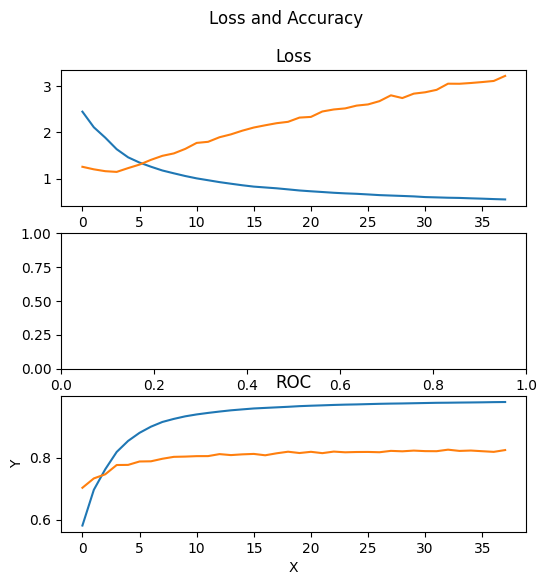

In [32]:
fig, axes = plt.subplots(3, 1, figsize=(6, 6))
axes[0].plot(history.history['loss'], label='train_loss')
axes[0].plot(history.history['val_loss'], label='val_loss')
axes[0].set_title('Loss')
# axes[1].plot(history.history['accuracy'], label='train_accuracy')
# axes[1].plot(history.history['val_accuracy'], label='val_accuracy')
# axes[1].set_title('Accuracy')
axes[2].plot(history.history['AUC'], label='train_AUC')
axes[2].plot(history.history['val_AUC'], label='val_AUC')
# axes[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[2].set_title('ROC')
# axes[2].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
# axes[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# axes[2].set_title('ROC')

# 添加整个图表的标题和横纵坐标标签
fig.suptitle('Loss and Accuracy')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [33]:
print(result)
print('============val_data===================')
print(classification_report(y_test, preds, target_names=names, digits=4))

{'loss': 3.120810031890869, 'auc': 0.821916401386261}
============val_data===================
                     precision    recall  f1-score   support

     Android_Adware     0.8163    0.6109    0.6988     13905
Android_SMS_Malware     0.7480    0.6152    0.6751      6141
  Android_Scareware     0.5778    0.6333    0.6043     10823
             Benign     0.2261    0.5930    0.3274      2187

           accuracy                         0.6178     33056
          macro avg     0.5920    0.6131    0.5764     33056
       weighted avg     0.6865    0.6178    0.6389     33056



In [34]:
config = ModelConfig(
    nets=['autoint_nets'],
    categorical_columns=categorical_columns,
    auto_discrete=True,
    auto_categorize=True,
    metrics=['AUC'],
    earlystopping_patience=5,
    embeddings_output_dim=100,
    embedding_dropout=0.3,
    autoint_params={
        'num_attention': 5,
        'num_heads': 2,
        'dropout_rate': 0.2,
        'use_residual': True
    },
#     optimizer=keras.optimizers.RMSprop(),

)
dt = deeptable.DeepTable(config=config)

In [35]:
model, history = dt.fit(x_train, y_train, epochs=epochs, validation_data=(x_val, y_val),class_weight=class_weight,
                        batch_size=batch_size)

04-20 12:09:57 I deeptables.m.deeptable.py 338 - X.Shape=(264440, 80), y.Shape=(264440,), batch_size=1024, config=ModelConfig(name='conf-1', nets=['autoint_nets'], categorical_columns=['Source Port', 'Destination Port', 'Protocol', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags'], exclude_columns=[], task='auto', pos_label=None, metrics=['AUC'], auto_categorize=True, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, embeddings_output_dim=100, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0, embedding_dropout=0.3, stacking_op='add', output_use_bias=True, apply_class_weight=False, optimizer='auto', loss='auto', dnn_params={'hidden_units': ((128, 0, False), (64, 0, False)), 'activation': 'relu'}, autoint_params={'num_attent

F:\anaconda3\envs\dxtf\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
F:\anaconda3\envs\dxtf\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
F:\anaconda3\envs\dxtf\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
F:\anaconda3\envs\dxtf\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of 

F:\anaconda3\envs\dxtf\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
F:\anaconda3\envs\dxtf\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
F:\anaconda3\envs\dxtf\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
F:\anaconda3\envs\dxtf\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of 

04-20 12:10:00 I deeptables.m.preprocessor.py 404 - Discretization taken 1.9273722171783447s
04-20 12:10:01 I deeptables.m.preprocessor.py 196 - fit_transform taken 3.718108654022217s
04-20 12:10:01 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-20 12:10:01 I deeptables.m.preprocessor.py 249 - transform_X taken 0.3131742477416992s
04-20 12:10:01 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-20 12:10:01 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0009975433349609375s
04-20 12:10:01 I deeptables.m.deeptable.py 354 - Training...
04-20 12:10:01 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_auc, patience:5, mode:max
1 Physical GPUs, 1 Logical GPUs
04-20 12:10:01 I deeptables.u.dataset_generator.py 240 - create dataset generator with _TFDGForPandas, batch_size=1024, shuffle=True, drop_remainder=True
04-20 12:10:02 I deeptables.u.dataset_generator.py 240 - create dataset generator with _TFDGForPandas, batch_size=1024, shuf

In [36]:
#evaluation
result = dt.evaluate(x_test,y_test)
print(result)

#scoring
preds = dt.predict(x_test)

04-20 12:39:16 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-20 12:39:16 I deeptables.m.preprocessor.py 249 - transform_X taken 0.3261270523071289s
04-20 12:39:16 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-20 12:39:16 I deeptables.m.preprocessor.py 236 - transform_y taken 0.000997304916381836s
04-20 12:39:16 I deeptables.m.deepmodel.py 158 - Performing evaluation...
04-20 12:39:16 I deeptables.u.dataset_generator.py 240 - create dataset generator with _TFDGForPandas, batch_size=256, shuffle=False, drop_remainder=False
{'loss': 2.8248157501220703, 'auc': 0.8027924299240112}
04-20 12:39:19 I deeptables.m.deeptable.py 685 - Perform prediction...
04-20 12:39:19 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-20 12:39:20 I deeptables.m.preprocessor.py 249 - transform_X taken 0.3171517848968506s
04-20 12:39:20 I deeptables.m.deepmodel.py 130 - Performing predictions...
04-20 12:39:20 I deeptables.u.dataset_generator.py 240 - create dataset generator with _TF

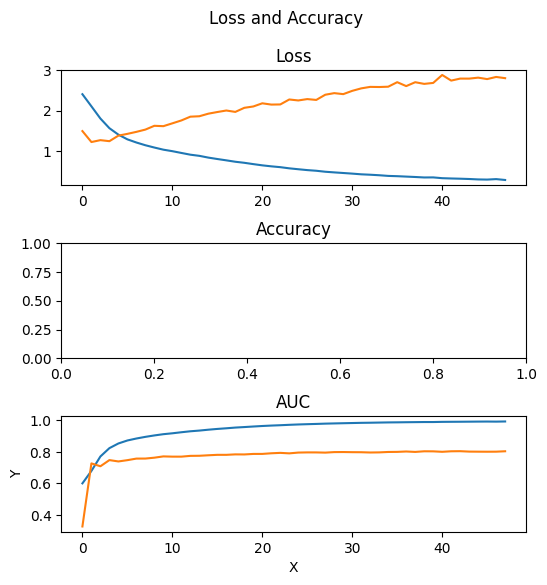

In [37]:
fig, axes = plt.subplots(3, 1, figsize=(6, 6))
axes[0].plot(history.history['loss'], label='train_loss')
axes[0].plot(history.history['val_loss'], label='val_loss')
axes[0].set_title('Loss')
# axes[1].plot(history.history['accuracy'], label='train_accuracy')
# axes[1].plot(history.history['val_accuracy'], label='val_accuracy')
axes[1].set_title('Accuracy')
axes[2].plot(history.history['AUC'], label='train_AUC')
axes[2].plot(history.history['val_AUC'], label='val_AUC')
axes[2].set_title('AUC')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)
fig.suptitle('Loss and Accuracy')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [38]:
print(result)
print('============val_data===================')
print(classification_report(y_test, preds, target_names=names, digits=4))

{'loss': 2.8248157501220703, 'auc': 0.8027924299240112}
============val_data===================
                     precision    recall  f1-score   support

     Android_Adware     0.6982    0.6731    0.6854     13905
Android_SMS_Malware     0.5544    0.5890    0.5712      6141
  Android_Scareware     0.5823    0.5304    0.5552     10823
             Benign     0.3078    0.4600    0.3688      2187

           accuracy                         0.5967     33056
          macro avg     0.5357    0.5631    0.5451     33056
       weighted avg     0.6077    0.5967    0.6006     33056



In [125]:
config = ModelConfig(
    metrics=['AUC'],
#     auto_discrete=True,
    auto_categorize=True,
#     auto_imputation=False,
    embeddings_output_dim=100, 
    dense_dropout=0.3,
#     embeddings_initializer='he_normal',
    embeddings_regularizer='l2',
#     categorical_columns=categorical_columns,
    optimizer='Adagrad',
    stacking_op='concat',
    apply_gbm_features=True,
    nets =['fm_nets'],
    earlystopping_patience=5,
)
dt = deeptable.DeepTable(config=config)

In [126]:
model, history = dt.fit(x_train, y_train, epochs=epochs, validation_data=(x_val, y_val),class_weight=class_weight,
                        batch_size=batch_size)

04-23 01:44:32 I deeptables.m.deeptable.py 338 - X.Shape=(263373, 76), y.Shape=(263373,), batch_size=1024, config=ModelConfig(name='conf-1', nets=['fm_nets'], categorical_columns='auto', exclude_columns=[], task='auto', pos_label=None, metrics=['AUC'], auto_categorize=True, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=False, auto_discard_unique=True, apply_gbm_features=True, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, embeddings_output_dim=100, embeddings_initializer='uniform', embeddings_regularizer='l2', embeddings_activity_regularizer=None, dense_dropout=0.3, embedding_dropout=0.3, stacking_op='concat', output_use_bias=True, apply_class_weight=False, optimizer='Adagrad', loss='auto', dnn_params={'hidden_units': ((128, 0, False), (64, 0, False)), 'activation': 'relu'}, autoint_params={'num_attention': 3, 'num_heads': 1, 'dropout_rate': 0, 'use_residual': True}, fgcnn_params={'fg_filters': (14, 16), '

04-23 01:53:22 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-23 01:53:24 I deeptables.m.preprocessor.py 249 - transform_X taken 1.8301548957824707s
04-23 01:53:24 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-23 01:53:24 I deeptables.m.preprocessor.py 236 - transform_y taken 0.002991914749145508s
04-23 01:53:25 I deeptables.m.deepmodel.py 158 - Performing evaluation...
04-23 01:53:25 I deeptables.u.dataset_generator.py 240 - create dataset generator with _TFDGForPandas, batch_size=256, shuffle=False, drop_remainder=False
{'loss': 3.6614394187927246, 'auc': 0.6239424347877502}
04-23 01:53:29 I deeptables.m.deeptable.py 685 - Perform prediction...
04-23 01:53:29 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-23 01:53:31 I deeptables.m.preprocessor.py 249 - transform_X taken 1.8795161247253418s
04-23 01:53:31 I deeptables.m.deepmodel.py 130 - Performing predictions...
04-23 01:53:31 I deeptables.u.dataset_generator.py 240 - create dataset generator with _TF

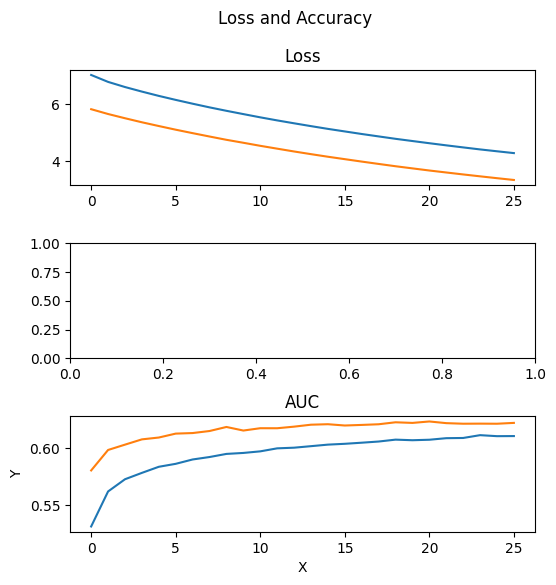

{'loss': 3.6614394187927246, 'auc': 0.6239424347877502}
============val_data===================
                     precision    recall  f1-score   support

     Android_Adware     0.5739    0.4597    0.5105     13842
Android_SMS_Malware     0.3280    0.5382    0.4076      6109
  Android_Scareware     0.3702    0.2341    0.2868     10790
             Benign     0.0804    0.1839    0.1119      2181

           accuracy                         0.3821     32922
          macro avg     0.3381    0.3540    0.3292     32922
       weighted avg     0.4288    0.3821    0.3917     32922



In [127]:
result = dt.evaluate(x_test,y_test)
print(result)

#scoring
preds = dt.predict(x_test)

fig, axes = plt.subplots(3, 1, figsize=(6, 6))
axes[0].plot(history.history['loss'], label='train_loss')
axes[0].plot(history.history['val_loss'], label='val_loss')
axes[0].set_title('Loss')
# axes[1].plot(history.history['accuracy'], label='train_accuracy')
# axes[1].plot(history.history['val_accuracy'], label='val_accuracy')
# axes[1].set_title('Accuracy')
axes[2].plot(history.history['AUC'], label='train_AUC')
axes[2].plot(history.history['val_AUC'], label='val_AUC')
axes[2].set_title('AUC')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)
fig.suptitle('Loss and Accuracy')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

print(result)
print('============val_data===================')
print(classification_report(y_test, preds, target_names=names, digits=4))

In [105]:
config = ModelConfig(
    metrics=['AUC'],
    auto_discrete=False,
    auto_categorize=False,
    embeddings_output_dim=100, 
    nets =['dcn_nets'],
    earlystopping_patience=5,
    apply_gbm_features=True,
    dnn_params={
        'hidden_units': ((64, 0.2, True), (64, 0.2, True),(64, 0.2, True),(64, 0.2, True),
                         (64, 0.2, True),(64, 0.2, True),(64, 0.2, True),(64, 0.2, True),
                         (64, 0.2, True),(64, 0.2, True)),
#         'hidden_units':((300, 0.3, True),(300, 0.3, True)),
        'use_bn': True,
        'learning_rate': 0.01,
        'activation': 'relu',
    },
#     pnn_params={
#         'outer_product_kernel_type': 'vec',
#     },
#     optimizer='Adamax'
)
dt = deeptable.DeepTable(config=config)

In [43]:
model, history = dt.fit(x_train, y_train, epochs=epochs, validation_data=(x_val, y_val),class_weight=class_weight,
                        batch_size=batch_size)

04-20 12:49:07 I deeptables.m.deeptable.py 338 - X.Shape=(264440, 80), y.Shape=(264440,), batch_size=1024, config=ModelConfig(name='conf-1', nets=['dcn_nets'], categorical_columns='auto', exclude_columns=[], task='auto', pos_label=None, metrics=['AUC'], auto_categorize=False, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=False, auto_discard_unique=True, apply_gbm_features=True, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, embeddings_output_dim=100, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0, embedding_dropout=0.3, stacking_op='add', output_use_bias=True, apply_class_weight=False, optimizer='auto', loss='auto', dnn_params={'hidden_units': ((64, 0.2, True), (64, 0.2, True), (64, 0.2, True), (64, 0.2, True), (64, 0.2, True), (64, 0.2, True), (64, 0.2, True), (64, 0.2, True), (64, 0.2, True), (64, 0.2, True)), 'use_bn': True, 'learning

04-22 23:49:07 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-22 23:49:09 I deeptables.m.preprocessor.py 249 - transform_X taken 1.8431055545806885s
04-22 23:49:09 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-22 23:49:09 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0029916763305664062s
04-22 23:49:09 I deeptables.m.deepmodel.py 158 - Performing evaluation...
04-22 23:49:09 I deeptables.u.dataset_generator.py 240 - create dataset generator with _TFDGForPandas, batch_size=256, shuffle=False, drop_remainder=False
{'loss': 1.2928005456924438, 'auc': 0.6218370795249939}
04-22 23:49:11 I deeptables.m.deeptable.py 685 - Perform prediction...
04-22 23:49:11 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-22 23:49:13 I deeptables.m.preprocessor.py 249 - transform_X taken 1.8246698379516602s
04-22 23:49:13 I deeptables.m.deepmodel.py 130 - Performing predictions...
04-22 23:49:13 I deeptables.u.dataset_generator.py 240 - create dataset generator with _T

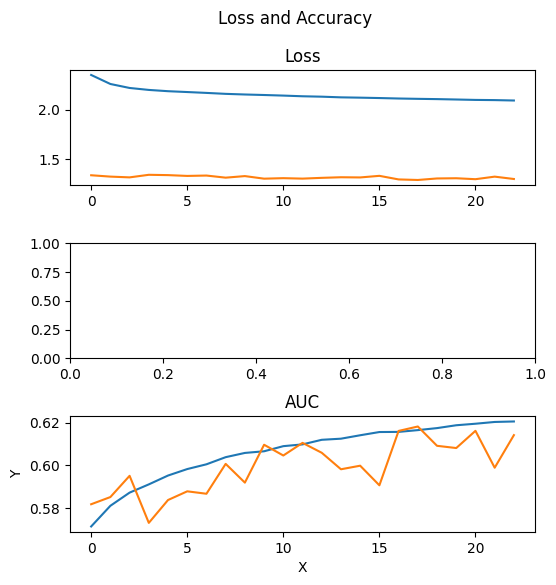

{'loss': 1.2928005456924438, 'auc': 0.6218370795249939}
============val_data===================
                     precision    recall  f1-score   support

     Android_Adware     0.5996    0.1766    0.2729     13842
Android_SMS_Malware     0.2155    0.3785    0.2746      6109
  Android_Scareware     0.3733    0.3445    0.3583     10790
             Benign     0.1336    0.4998    0.2109      2181

           accuracy                         0.2905     32922
          macro avg     0.3305    0.3498    0.2792     32922
       weighted avg     0.4233    0.2905    0.2971     32922



In [104]:
result = dt.evaluate(x_test,y_test)
print(result)

#scoring
preds = dt.predict(x_test)

fig, axes = plt.subplots(3, 1, figsize=(6, 6))
axes[0].plot(history.history['loss'], label='train_loss')
axes[0].plot(history.history['val_loss'], label='val_loss')
axes[0].set_title('Loss')
# axes[1].plot(history.history['accuracy'], label='train_accuracy')
# axes[1].plot(history.history['val_accuracy'], label='val_accuracy')
# axes[1].set_title('Accuracy')
axes[2].plot(history.history['AUC'], label='train_AUC')
axes[2].plot(history.history['val_AUC'], label='val_AUC')
axes[2].set_title('AUC')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)
fig.suptitle('Loss and Accuracy')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

print(result)
print('============val_data===================')
print(classification_report(y_test, preds, target_names=names, digits=4))

In [45]:
config = ModelConfig(
    nets=['dnn_nets','autoint_nets','fm_nets'],
    categorical_columns=categorical_columns,
    auto_discrete=True,
    auto_categorize=True,
    metrics=['AUC'],
    dnn_params={
        'hidden_units': ((300, 0.3, True), (300, 0.3, True)),
        'use_bn': True,
        'learning_rate': 0.01,
        'activation': 'relu',
    },
    earlystopping_patience=5,
    apply_gbm_features=True,
    embeddings_output_dim=100,
    autoint_params={
        'num_attention': 3,
        'num_heads': 1,
        'dropout_rate': 0.2,
        'use_residual': True
    },
    stacking_op='add',
)

dt = deeptable.DeepTable(config=config)

In [46]:
model, history = dt.fit(x_train, y_train, epochs=epochs, validation_data=(x_val, y_val),class_weight=class_weight,
                        batch_size=batch_size)

04-20 12:54:28 I deeptables.m.deeptable.py 338 - X.Shape=(264440, 80), y.Shape=(264440,), batch_size=1024, config=ModelConfig(name='conf-1', nets=['fm_nets', 'dnn_nets', 'autoint_nets'], categorical_columns=['Source Port', 'Destination Port', 'Protocol', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags'], exclude_columns=[], task='auto', pos_label=None, metrics=['AUC'], auto_categorize=True, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=True, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, embeddings_output_dim=100, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0, embedding_dropout=0.3, stacking_op='add', output_use_bias=True, apply_class_weight=False, optimizer='auto', loss='auto', dnn_params={'hidden_units': ((300, 0.3, True), (300, 0.3, True)), 'use_bn': True, 'learning

F:\anaconda3\envs\dxtf\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
F:\anaconda3\envs\dxtf\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
F:\anaconda3\envs\dxtf\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
F:\anaconda3\envs\dxtf\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of 

F:\anaconda3\envs\dxtf\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
F:\anaconda3\envs\dxtf\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
F:\anaconda3\envs\dxtf\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
F:\anaconda3\envs\dxtf\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of 

04-20 12:54:32 I deeptables.m.preprocessor.py 404 - Discretization taken 2.0026743412017822s
04-20 12:54:32 I deeptables.m.preprocessor.py 423 - Extracting GBM features...
04-20 12:54:32 I hypernets.t.sklearn_ex.py 640 - LightGBM task:multiclass
04-20 12:54:36 I deeptables.m.preprocessor.py 434 - Extracting gbm features taken 3.859729290008545s
04-20 12:54:40 I deeptables.m.preprocessor.py 196 - fit_transform taken 11.620600700378418s
04-20 12:54:40 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-20 12:54:41 I deeptables.m.preprocessor.py 249 - transform_X taken 0.5854346752166748s
04-20 12:54:41 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-20 12:54:41 I deeptables.m.preprocessor.py 236 - transform_y taken 0.002992391586303711s
04-20 12:54:42 I deeptables.m.deeptable.py 354 - Training...
04-20 12:54:42 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_auc, patience:5, mode:max
1 Physical GPUs, 1 Logical GPUs
04-20 12:54:42 I deeptab

F:\anaconda3\envs\dxtf\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


04-20 13:01:25 I deeptables.m.deeptable.py 704 - Model has been saved to:dt_output/dt_20230420125428_fm_nets_dnn_nets_autoint_nets/fm_nets+dnn_nets+autoint_nets.h5


04-20 13:01:25 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-20 13:01:26 I deeptables.m.preprocessor.py 249 - transform_X taken 0.5659923553466797s
04-20 13:01:26 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-20 13:01:26 I deeptables.m.preprocessor.py 236 - transform_y taken 0.001995086669921875s
04-20 13:01:26 I deeptables.m.deepmodel.py 158 - Performing evaluation...
04-20 13:01:26 I deeptables.u.dataset_generator.py 240 - create dataset generator with _TFDGForPandas, batch_size=256, shuffle=False, drop_remainder=False
{'loss': 1.1358505487442017, 'auc': 0.7748055458068848}
04-20 13:01:31 I deeptables.m.deeptable.py 685 - Perform prediction...
04-20 13:01:31 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-20 13:01:31 I deeptables.m.preprocessor.py 249 - transform_X taken 0.5734765529632568s
04-20 13:01:31 I deeptables.m.deepmodel.py 130 - Performing predictions...
04-20 13:01:31 I deeptables.u.dataset_generator.py 240 - create dataset generator with _TF

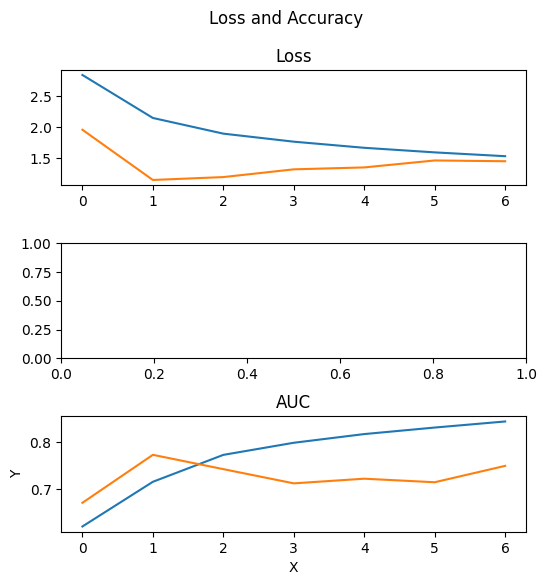

{'loss': 1.1358505487442017, 'auc': 0.7748055458068848}
============val_data===================
                     precision    recall  f1-score   support

     Android_Adware     0.4762    0.9364    0.6314     13905
Android_SMS_Malware     0.9001    0.3229    0.4753      6141
  Android_Scareware     0.2958    0.0502    0.0858     10823
             Benign     0.1307    0.1001    0.1134      2187

           accuracy                         0.4769     33056
          macro avg     0.4507    0.3524    0.3265     33056
       weighted avg     0.4730    0.4769    0.3895     33056



In [47]:
result = dt.evaluate(x_test,y_test)
print(result)

#scoring
preds = dt.predict(x_test)

fig, axes = plt.subplots(3, 1, figsize=(6, 6))
axes[0].plot(history.history['loss'], label='train_loss')
axes[0].plot(history.history['val_loss'], label='val_loss')
axes[0].set_title('Loss')
# axes[1].plot(history.history['accuracy'], label='train_accuracy')
# axes[1].plot(history.history['val_accuracy'], label='val_accuracy')
# axes[1].set_title('Accuracy')
axes[2].plot(history.history['AUC'], label='train_AUC')
axes[2].plot(history.history['val_AUC'], label='val_AUC')
axes[2].set_title('AUC')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)
fig.suptitle('Loss and Accuracy')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

print(result)
print('============val_data===================')
print(classification_report(y_test, preds, target_names=names, digits=4))

In [48]:
config = ModelConfig(
    nets=['autoint_nets','fm_nets'],
    categorical_columns=categorical_columns,
    auto_discrete=True,
    auto_categorize=True,
    metrics=['AUC'],
    dnn_params={
        'hidden_units':((300, 0.3, True),(300, 0.3, True)),
        'use_bn': True,
        'learning_rate': 0.01,
        'activation': 'relu',
    },
    earlystopping_patience=5,
    apply_gbm_features=True,
    embeddings_output_dim=100,
    autoint_params={
        'num_attention': 3,
        'num_heads': 1,
        'dropout_rate': 0.2,
        'use_residual': True
    },
    stacking_op='add',
)

dt = deeptable.DeepTable(config=config)

In [49]:
model, history = dt.fit(x_train, y_train, epochs=epochs, validation_data=(x_val, y_val),class_weight=class_weight,
                        batch_size=batch_size,shuffle=True)

04-20 13:01:38 I deeptables.m.deeptable.py 338 - X.Shape=(264440, 80), y.Shape=(264440,), batch_size=1024, config=ModelConfig(name='conf-1', nets=['fm_nets', 'autoint_nets'], categorical_columns=['Source Port', 'Destination Port', 'Protocol', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags'], exclude_columns=[], task='auto', pos_label=None, metrics=['AUC'], auto_categorize=True, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=True, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, embeddings_output_dim=100, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0, embedding_dropout=0.3, stacking_op='add', output_use_bias=True, apply_class_weight=False, optimizer='auto', loss='auto', dnn_params={'hidden_units': ((300, 0.3, True), (300, 0.3, True)), 'use_bn': True, 'learning_rate': 0.01

F:\anaconda3\envs\dxtf\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
F:\anaconda3\envs\dxtf\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
F:\anaconda3\envs\dxtf\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
F:\anaconda3\envs\dxtf\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of 

F:\anaconda3\envs\dxtf\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
F:\anaconda3\envs\dxtf\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
F:\anaconda3\envs\dxtf\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
F:\anaconda3\envs\dxtf\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of 

04-20 13:01:41 I deeptables.m.preprocessor.py 404 - Discretization taken 2.0211267471313477s
04-20 13:01:41 I deeptables.m.preprocessor.py 423 - Extracting GBM features...
04-20 13:01:42 I hypernets.t.sklearn_ex.py 640 - LightGBM task:multiclass
04-20 13:01:45 I deeptables.m.preprocessor.py 434 - Extracting gbm features taken 3.9500479698181152s
04-20 13:01:50 I deeptables.m.preprocessor.py 196 - fit_transform taken 11.781244039535522s
04-20 13:01:50 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-20 13:01:51 I deeptables.m.preprocessor.py 249 - transform_X taken 0.6338100433349609s
04-20 13:01:51 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-20 13:01:51 I deeptables.m.preprocessor.py 236 - transform_y taken 0.001994609832763672s
04-20 13:01:51 I deeptables.m.deeptable.py 354 - Training...
04-20 13:01:51 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_auc, patience:5, mode:max
1 Physical GPUs, 1 Logical GPUs
04-20 13:01:51 I deepta

F:\anaconda3\envs\dxtf\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


04-20 13:41:38 I deeptables.m.deeptable.py 704 - Model has been saved to:dt_output/dt_20230420130138_fm_nets_autoint_nets/fm_nets+autoint_nets.h5


04-20 13:41:38 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-20 13:41:39 I deeptables.m.preprocessor.py 249 - transform_X taken 0.6193435192108154s
04-20 13:41:39 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-20 13:41:39 I deeptables.m.preprocessor.py 236 - transform_y taken 0.002992391586303711s
04-20 13:41:40 I deeptables.m.deepmodel.py 158 - Performing evaluation...
04-20 13:41:40 I deeptables.u.dataset_generator.py 240 - create dataset generator with _TFDGForPandas, batch_size=256, shuffle=False, drop_remainder=False
{'loss': 6.319366931915283, 'auc': 0.7930574417114258}
04-20 13:41:44 I deeptables.m.deeptable.py 685 - Perform prediction...
04-20 13:41:44 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-20 13:41:44 I deeptables.m.preprocessor.py 249 - transform_X taken 0.6004047393798828s
04-20 13:41:44 I deeptables.m.deepmodel.py 130 - Performing predictions...
04-20 13:41:44 I deeptables.u.dataset_generator.py 240 - create dataset generator with _TFD

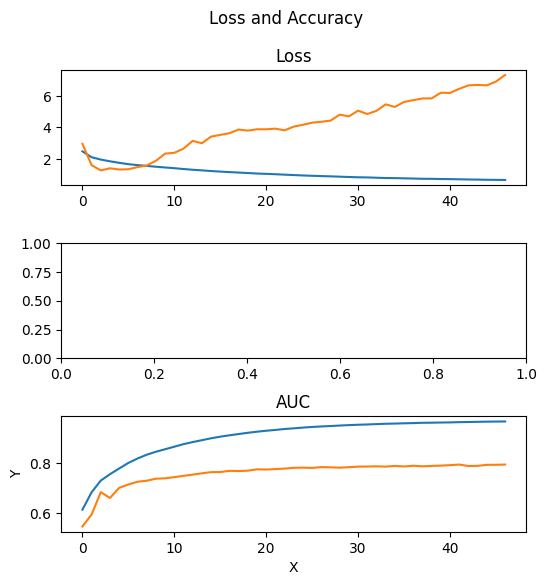

['fm_nets', 'autoint_nets']
{'loss': 6.319366931915283, 'auc': 0.7930574417114258}
============val_data===================
                     precision    recall  f1-score   support

     Android_Adware     0.6799    0.7399    0.7086     13905
Android_SMS_Malware     0.6620    0.6305    0.6459      6141
  Android_Scareware     0.7347    0.4756    0.5774     10823
             Benign     0.2368    0.5487    0.3309      2187

           accuracy                         0.6204     33056
          macro avg     0.5783    0.5987    0.5657     33056
       weighted avg     0.6652    0.6204    0.6290     33056



In [50]:
result = dt.evaluate(x_test,y_test)
print(result)

#scoring
preds = dt.predict(x_test)

fig, axes = plt.subplots(3, 1, figsize=(6, 6))
axes[0].plot(history.history['loss'], label='train_loss')
axes[0].plot(history.history['val_loss'], label='val_loss')
axes[0].set_title('Loss')
# axes[1].plot(history.history['accuracy'], label='train_accuracy')
# axes[1].plot(history.history['val_accuracy'], label='val_accuracy')
# axes[1].set_title('Accuracy')
axes[2].plot(history.history['AUC'], label='train_AUC')
axes[2].plot(history.history['val_AUC'], label='val_AUC')
axes[2].set_title('AUC')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)
fig.suptitle('Loss and Accuracy')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(config.nets)
print(result)
print('============val_data===================')
print(classification_report(y_test, preds, target_names=names, digits=4))

In [51]:
from deeptables.models import deepnets

In [52]:
batch_size=128

In [53]:
config = ModelConfig(
    metrics=['AUC'],
#     auto_discrete=True,
#     auto_categorize=True,
    embeddings_output_dim=100, 
    nets =deepnets.xDeepFM,
    earlystopping_patience=5,
    apply_gbm_features=True,
#     dnn_params={
#         'hidden_units': ((64, 0.2, True), (32, 0.2, True),(16, 0.2, True),(16, 0.2, True),(8, 0.2, True),
#                          ),
#         'activation': 'relu',
#     },
)
dt = deeptable.DeepTable(config=config)

In [ ]:
model, history = dt.fit(x_train, y_train, epochs=epochs, validation_data=(x_val, y_val),class_weight=class_weight,
                        batch_size=batch_size,shuffle=True)

04-20 13:41:49 I deeptables.m.deeptable.py 338 - X.Shape=(264440, 80), y.Shape=(264440,), batch_size=128, config=ModelConfig(name='conf-1', nets=['linear', 'dnn_nets', 'cin_nets'], categorical_columns='auto', exclude_columns=[], task='auto', pos_label=None, metrics=['AUC'], auto_categorize=False, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=False, auto_discard_unique=True, apply_gbm_features=True, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, embeddings_output_dim=100, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0, embedding_dropout=0.3, stacking_op='add', output_use_bias=True, apply_class_weight=False, optimizer='auto', loss='auto', dnn_params={'hidden_units': ((128, 0, False), (64, 0, False)), 'activation': 'relu'}, autoint_params={'num_attention': 3, 'num_heads': 1, 'dropout_rate': 0, 'use_residual': True}, fgcnn_params={'fg_filter

In [ ]:
result = dt.evaluate(x_test,y_test)
print(result)

#scoring
preds = dt.predict(x_test)

fig, axes = plt.subplots(3, 1, figsize=(6, 6))
axes[0].plot(history.history['loss'], label='train_loss')
axes[0].plot(history.history['val_loss'], label='val_loss')
axes[0].set_title('Loss')
# axes[1].plot(history.history['accuracy'], label='train_accuracy')
# axes[1].plot(history.history['val_accuracy'], label='val_accuracy')
# axes[1].set_title('Accuracy')
axes[2].plot(history.history['AUC'], label='train_AUC')
axes[2].plot(history.history['val_AUC'], label='val_AUC')
axes[2].set_title('AUC')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)
fig.suptitle('Loss and Accuracy')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(config.nets)
print(result)
print('============val_data===================')
print(classification_report(y_test, preds, target_names=names, digits=4))

In [ ]:
config = ModelConfig(
    metrics=['AUC'],
    auto_discrete=False,
    auto_categorize=False,
#     auto_imputation=False,
    embeddings_output_dim=300, 
#     embeddings_initializer='glorot_uniform',
    dense_dropout=0.3,
#     embeddings_regularizer='l2',
    categorical_columns=categorical_columns,
    stacking_op='add',
#     apply_gbm_features=True,
    nets =['fm_nets','linear','dnn_nets'],
    earlystopping_patience=5,
    dnn_params={
    'hidden_units': ((300, 0.2, False), (300, 0.2, False)),
    'dnn_activation': 'relu'
    },
    
)
dt = deeptable.DeepTable(config=config)

In [ ]:
model, history = dt.fit(x_train, y_train, epochs=epochs, validation_data=(x_val, y_val),class_weight=class_weight,
                        batch_size=batch_size,shuffle=True)

In [ ]:
result = dt.evaluate(x_test,y_test)
print(result)

#scoring
preds = dt.predict(x_test)

fig, axes = plt.subplots(3, 1, figsize=(6, 6))
axes[0].plot(history.history['loss'], label='train_loss')
axes[0].plot(history.history['val_loss'], label='val_loss')
axes[0].set_title('Loss')
# axes[1].plot(history.history['accuracy'], label='train_accuracy')
# axes[1].plot(history.history['val_accuracy'], label='val_accuracy')
# axes[1].set_title('Accuracy')
axes[2].plot(history.history['AUC'], label='train_AUC')
axes[2].plot(history.history['val_AUC'], label='val_AUC')
axes[2].set_title('AUC')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)
fig.suptitle('Loss and Accuracy')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(config.nets)
print(result)
print('============val_data===================')
print(classification_report(y_test, preds, target_names=names, digits=4))

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
x_ = data0.iloc[:, :-1]
y_ = data0.iloc[:, -1:].copy()
print('x_',x_)
print('=====================')
print('y_',y_)

# Select the top k features using mutual information
k = 10  # Choose the number of top features you want to select
selector = SelectKBest(mutual_info_classif, k=k)
selector.fit(x_, y_.values.ravel())

# Get the indices of the top k features
top_k_features_indices = selector.get_support(indices=True)

# Get the top k features
x_top_k = x_.iloc[:, top_k_features_indices]

In [50]:
import numpy as np
from functools import partial
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import roc_auc_score

In [65]:
def objective(params, X_train, y_train, X_val, y_val, task='multiclass'):
    senet_pooling_op, senet_reduction_ratio, bilinear_type = params
    # 创建模型配置
    config = ModelConfig(
        nets=['fibi_nets'],
        categorical_columns=categorical_columns,
        metrics=['AUC', 'accuracy'],
        pnn_params={
            'outer_product_kernel_type': 'mat',
        },
        afm_params={
            'attention_factor': 5,
            'dropout_rate': 0.3,
        },
        fgcnn_params={
            'fg_filters': (14, 16),
            'fg_widths': (7, 7),
            'fg_pool_widths': (2, 2),
            'fg_new_feat_filters': (2, 2),
        },
        fibinet_params={
            'senet_pooling_op': senet_pooling_op,
            'senet_reduction_ratio': senet_reduction_ratio,
            'bilinear_type': bilinear_type,
        },
        cross_params={
            'num_cross_layer': 5,
        },
        autoint_params={
            'num_attention': 3,
            'num_heads': 1,
            'dropout_rate': 0,
            'use_residual': True
        },
        apply_class_weight=True,
        stacking_op='add',
        dnn_params={
            'hidden_units':((128, 0.2, False),(128, 0.2, False)),
            'activation': 'relu',
        },
        cin_params={
            'cross_layer_size': (128, 128),
            'activation': 'relu',
            'use_residual': False,
            'use_bias': False,
            'direct': False,
            'reduce_D': False,
        },
        earlystopping_patience=5,
        embeddings_output_dim=100,
        dense_dropout=0.2,
        home_dir='E:/temp',

    )

    # 用更新后的配置创建和训练模型
    print('===================================================')
    print(config)
    print('===================================================')
    dt = DeepTable(config=config)
    model, history = dt.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val),class_weight=class_weight,
                        batch_size=1024,shuffle=True)

    print(history.history)
    best_score = np.max(history.history['val_AUC'])

    return -best_score

In [66]:
param_space = [
    Categorical(['max', 'mean'], name='senet_pooling_op'),
    Integer(2, 6, name='senet_reduction_ratio'),
    Categorical(['field_interaction', 'full'], name='bilinear_type'),
]

In [67]:
objective_with_data = partial(objective, X_train=x_train, y_train=y_train, X_val=x_test, y_val=y_test)

# 运行超参数搜索
result = gp_minimize(objective_with_data, param_space, n_calls=50, random_state=42)

ModelConfig(name='conf-1', nets=['fibi_nets'], categorical_columns=['Protocol', 'Fwd PSH Flags', 'Source IP', 'Destination IP', 'Source Port', 'Destination Port', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags'], exclude_columns=[], task='auto', pos_label=None, metrics=['AUC', 'accuracy'], auto_categorize=False, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=False, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, embeddings_output_dim=100, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0.2, embedding_dropout=0.3, stacking_op='add', output_use_bias=True, apply_class_weight=True, optimizer='auto', loss='auto', dnn_params={'hidden_units': ((128, 0.2, False), (128, 0.2, False)), 'activation': 'relu'}, autoint_params={'num_attention': 3, 'num_heads': 1, 'dropout_rate': 0, 'use_residual': True},

277/277 [==============================] - 12s 42ms/step - loss: 0.2950 - auc: 0.9922 - accuracy: 0.9143 - val_loss: 1.1427 - val_auc: 0.8901 - val_accuracy: 0.6880
Epoch 11/200
277/277 [==============================] - 12s 42ms/step - loss: 0.2744 - auc: 0.9932 - accuracy: 0.9198 - val_loss: 1.1726 - val_auc: 0.8892 - val_accuracy: 0.6898
Epoch 12/200
277/277 [==============================] - 12s 42ms/step - loss: 0.2584 - auc: 0.9939 - accuracy: 0.9234 - val_loss: 1.1751 - val_auc: 0.8904 - val_accuracy: 0.6926
Epoch 13/200
277/277 [==============================] - 12s 42ms/step - loss: 0.2450 - auc: 0.9946 - accuracy: 0.9269 - val_loss: 1.1910 - val_auc: 0.8899 - val_accuracy: 0.6930
Epoch 14/200
277/277 [==============================] - 12s 42ms/step - loss: 0.2355 - auc: 0.9950 - accuracy: 0.9287 - val_loss: 1.2060 - val_auc: 0.8900 - val_accuracy: 0.6921
Epoch 15/200
277/277 [==============================] - 12s 42ms/step - loss: 0.2282 - auc: 0.9953 - accuracy: 0.9303 - val

04-25 15:26:50 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 15:26:50 I deeptables.m.preprocessor.py 249 - transform_X taken 0.13763189315795898s
04-25 15:26:50 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-25 15:26:50 I deeptables.m.preprocessor.py 236 - transform_y taken 0.001995086669921875s
04-25 15:26:50 I deeptables.m.deeptable.py 354 - Training...
04-25 15:26:50 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_auc, patience:5, mode:max
1 Physical GPUs, 1 Logical GPUs
04-25 15:26:50 I deeptables.u.dataset_generator.py 240 - create dataset generator with _TFDGForPandas, batch_size=1024, shuffle=True, drop_remainder=True
04-25 15:26:50 I deeptables.u.dataset_generator.py 240 - create dataset generator with _TFDGForPandas, batch_size=1024, shuffle=True, drop_remainder=True
04-25 15:26:50 I deeptables.m.deepmodel.py 231 - Building model...
04-25 15:26:51 I deeptables.m.deepmodel.py 287 - >>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<

04-25 15:31:00 I deeptables.m.deeptable.py 339 - metrics:['AUC', 'accuracy']
04-25 15:31:01 I hypernets.t.toolbox.py 346 - 4 class detected, inferred as a [multiclass classification] task
04-25 15:31:01 I deeptables.m.preprocessor.py 261 - Preparing features...
04-25 15:31:01 I deeptables.m.preprocessor.py 336 - Preparing features taken 0.3899877071380615s
04-25 15:31:01 I deeptables.m.preprocessor.py 341 - Data imputation...
04-25 15:31:02 I deeptables.m.preprocessor.py 383 - Imputation taken 0.5271062850952148s
04-25 15:31:02 I deeptables.m.preprocessor.py 388 - Categorical encoding...
04-25 15:31:02 I deeptables.m.preprocessor.py 393 - Categorical encoding taken 0.2957158088684082s
04-25 15:31:02 I deeptables.m.preprocessor.py 196 - fit_transform taken 1.45017409324646s
04-25 15:31:02 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 15:31:02 I deeptables.m.preprocessor.py 249 - transform_X taken 0.13614225387573242s
04-25 15:31:02 I deeptables.m.preprocessor.py 230 - Tran

04-25 15:37:03 I deeptables.m.preprocessor.py 383 - Imputation taken 0.5091555118560791s
04-25 15:37:03 I deeptables.m.preprocessor.py 388 - Categorical encoding...
04-25 15:37:03 I deeptables.m.preprocessor.py 393 - Categorical encoding taken 0.29025888442993164s
04-25 15:37:03 I deeptables.m.preprocessor.py 196 - fit_transform taken 1.4127957820892334s
04-25 15:37:03 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 15:37:03 I deeptables.m.preprocessor.py 249 - transform_X taken 0.13614320755004883s
04-25 15:37:03 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-25 15:37:03 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0009970664978027344s
04-25 15:37:03 I deeptables.m.deeptable.py 354 - Training...
04-25 15:37:03 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_auc, patience:5, mode:max
1 Physical GPUs, 1 Logical GPUs
04-25 15:37:03 I deeptables.u.dataset_generator.py 240 - create dataset generator with _TFDGForPandas, b

Epoch 33/200
277/277 [==============================] - 12s 42ms/step - loss: 0.1900 - auc: 0.9967 - accuracy: 0.9376 - val_loss: 1.4085 - val_auc: 0.8825 - val_accuracy: 0.6941
Epoch 34/200
277/277 [==============================] - 12s 42ms/step - loss: 0.1881 - auc: 0.9967 - accuracy: 0.9380 - val_loss: 1.4197 - val_auc: 0.8823 - val_accuracy: 0.6987
Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
04-25 15:43:48 I deeptables.m.deepmodel.py 122 - Training finished.
04-25 15:43:48 I deeptables.m.deeptable.py 370 - Training finished.
04-25 15:43:48 I deeptables.m.deeptable.py 704 - Model has been saved to:E:/temp/dt_20230425153701_fibi_nets/fibi_nets.h5
{'loss': [1.948061227798462, 1.4290564060211182, 1.0730420351028442, 0.8216177225112915, 0.6815186738967896, 0.5857614874839783, 0.517196536064148, 0.46751827001571655, 0.42861995100975037, 0.3986481726169586, 0.3695872128009796, 0.3465123176574707, 0.3288988173007965, 0.31007060408592224, 0.293682366

04-25 15:43:48 I deeptables.m.deeptable.py 339 - metrics:['AUC', 'accuracy']
04-25 15:43:49 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 15:43:50 I deeptables.m.preprocessor.py 249 - transform_X taken 0.9504809379577637s
04-25 15:43:50 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-25 15:43:50 I deeptables.m.preprocessor.py 236 - transform_y taken 0.006981372833251953s
04-25 15:43:50 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 15:43:50 I deeptables.m.preprocessor.py 249 - transform_X taken 0.1411287784576416s
04-25 15:43:50 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-25 15:43:50 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0009975433349609375s
04-25 15:43:50 I deeptables.m.deeptable.py 354 - Training...
04-25 15:43:50 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_auc, patience:5, mode:max
1 Physical GPUs, 1 Logical GPUs
04-25 15:43:50 I deeptables.u.dataset_generator.py 240 - create d

04-25 15:47:37 I deeptables.m.deeptable.py 339 - metrics:['AUC', 'accuracy']
04-25 15:47:37 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 15:47:38 I deeptables.m.preprocessor.py 249 - transform_X taken 0.951491117477417s
04-25 15:47:38 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-25 15:47:38 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0069811344146728516s
04-25 15:47:38 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 15:47:38 I deeptables.m.preprocessor.py 249 - transform_X taken 0.13763213157653809s
04-25 15:47:38 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-25 15:47:38 I deeptables.m.preprocessor.py 236 - transform_y taken 0.001995563507080078s
04-25 15:47:38 I deeptables.m.deeptable.py 354 - Training...
04-25 15:47:38 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_auc, patience:5, mode:max
1 Physical GPUs, 1 Logical GPUs
04-25 15:47:38 I deeptables.u.dataset_generator.py 240 - create d

04-25 15:53:24 I deeptables.m.deeptable.py 339 - metrics:['AUC', 'accuracy']
04-25 15:53:25 I hypernets.t.toolbox.py 346 - 4 class detected, inferred as a [multiclass classification] task
04-25 15:53:25 I deeptables.m.preprocessor.py 261 - Preparing features...
04-25 15:53:25 I deeptables.m.preprocessor.py 336 - Preparing features taken 0.3889596462249756s
04-25 15:53:25 I deeptables.m.preprocessor.py 341 - Data imputation...
04-25 15:53:25 I deeptables.m.preprocessor.py 383 - Imputation taken 0.5106558799743652s
04-25 15:53:25 I deeptables.m.preprocessor.py 388 - Categorical encoding...
04-25 15:53:26 I deeptables.m.preprocessor.py 393 - Categorical encoding taken 0.28523755073547363s
04-25 15:53:26 I deeptables.m.preprocessor.py 196 - fit_transform taken 1.4097566604614258s
04-25 15:53:26 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 15:53:26 I deeptables.m.preprocessor.py 249 - transform_X taken 0.1356372833251953s
04-25 15:53:26 I deeptables.m.preprocessor.py 230 - Tr

04-25 15:57:27 I deeptables.m.deeptable.py 339 - metrics:['AUC', 'accuracy']
04-25 15:57:27 I hypernets.t.toolbox.py 346 - 4 class detected, inferred as a [multiclass classification] task
04-25 15:57:27 I deeptables.m.preprocessor.py 261 - Preparing features...
04-25 15:57:28 I deeptables.m.preprocessor.py 336 - Preparing features taken 0.3904716968536377s
04-25 15:57:28 I deeptables.m.preprocessor.py 341 - Data imputation...
04-25 15:57:28 I deeptables.m.preprocessor.py 383 - Imputation taken 0.5355784893035889s
04-25 15:57:28 I deeptables.m.preprocessor.py 388 - Categorical encoding...
04-25 15:57:28 I deeptables.m.preprocessor.py 393 - Categorical encoding taken 0.2877483367919922s
04-25 15:57:29 I deeptables.m.preprocessor.py 196 - fit_transform taken 1.4431860446929932s
04-25 15:57:29 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 15:57:29 I deeptables.m.preprocessor.py 249 - transform_X taken 0.13913393020629883s
04-25 15:57:29 I deeptables.m.preprocessor.py 230 - Tr

04-25 16:03:40 I deeptables.m.preprocessor.py 249 - transform_X taken 0.9529836177825928s
04-25 16:03:40 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-25 16:03:40 I deeptables.m.preprocessor.py 236 - transform_y taken 0.008976221084594727s
04-25 16:03:40 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 16:03:40 I deeptables.m.preprocessor.py 249 - transform_X taken 0.14012980461120605s
04-25 16:03:40 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-25 16:03:40 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0009975433349609375s
04-25 16:03:40 I deeptables.m.deeptable.py 354 - Training...
04-25 16:03:40 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_auc, patience:5, mode:max
1 Physical GPUs, 1 Logical GPUs
04-25 16:03:40 I deeptables.u.dataset_generator.py 240 - create dataset generator with _TFDGForPandas, batch_size=1024, shuffle=True, drop_remainder=True
04-25 16:03:40 I deeptables.u.dataset_generator.py 240 -

04-25 16:07:16 I deeptables.m.deeptable.py 339 - metrics:['AUC', 'accuracy']
04-25 16:07:17 I hypernets.t.toolbox.py 346 - 4 class detected, inferred as a [multiclass classification] task
04-25 16:07:17 I deeptables.m.preprocessor.py 261 - Preparing features...
04-25 16:07:17 I deeptables.m.preprocessor.py 336 - Preparing features taken 0.3949437141418457s
04-25 16:07:17 I deeptables.m.preprocessor.py 341 - Data imputation...
04-25 16:07:18 I deeptables.m.preprocessor.py 383 - Imputation taken 0.5275886058807373s
04-25 16:07:18 I deeptables.m.preprocessor.py 388 - Categorical encoding...
04-25 16:07:18 I deeptables.m.preprocessor.py 393 - Categorical encoding taken 0.28822922706604004s
04-25 16:07:18 I deeptables.m.preprocessor.py 196 - fit_transform taken 1.4341750144958496s
04-25 16:07:18 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 16:07:18 I deeptables.m.preprocessor.py 249 - transform_X taken 0.1331501007080078s
04-25 16:07:18 I deeptables.m.preprocessor.py 230 - Tr

04-25 16:13:39 I deeptables.m.deeptable.py 339 - metrics:['AUC', 'accuracy']


F:\anaconda3\envs\dxtf\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


04-25 16:13:40 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 16:13:41 I deeptables.m.preprocessor.py 249 - transform_X taken 0.9509820938110352s
04-25 16:13:41 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-25 16:13:41 I deeptables.m.preprocessor.py 236 - transform_y taken 0.006981372833251953s
04-25 16:13:41 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 16:13:41 I deeptables.m.preprocessor.py 249 - transform_X taken 0.14013147354125977s
04-25 16:13:41 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-25 16:13:41 I deeptables.m.preprocessor.py 236 - transform_y taken 0.001995086669921875s
04-25 16:13:41 I deeptables.m.deeptable.py 354 - Training...
04-25 16:13:41 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_auc, patience:5, mode:max
1 Physical GPUs, 1 Logical GPUs
04-25 16:13:41 I deeptables.u.dataset_generator.py 240 - create dataset generator with _TFDGForPandas, batch_size=1024, shuffle=True, drop_rem

ModelConfig(name='conf-1', nets=['fibi_nets'], categorical_columns=['Protocol', 'Fwd PSH Flags', 'Source IP', 'Destination IP', 'Source Port', 'Destination Port', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags'], exclude_columns=[], task='auto', pos_label=None, metrics=['AUC', 'accuracy'], auto_categorize=False, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=False, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, embeddings_output_dim=100, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0.2, embedding_dropout=0.3, stacking_op='add', output_use_bias=True, apply_class_weight=True, optimizer='auto', loss='auto', dnn_params={'hidden_units': ((128, 0.2, False), (128, 0.2, False)), 'activation': 'relu'}, autoint_params={'num_attention': 3, 'num_heads': 1, 'dropout_rate': 0, 'use_residual': True},

277/277 [==============================] - 12s 43ms/step - loss: 0.3926 - auc: 0.9859 - accuracy: 0.8852 - val_loss: 0.9972 - val_auc: 0.8816 - val_accuracy: 0.6639
Epoch 11/200
277/277 [==============================] - 12s 43ms/step - loss: 0.3698 - auc: 0.9875 - accuracy: 0.8911 - val_loss: 1.0089 - val_auc: 0.8827 - val_accuracy: 0.6667
Epoch 12/200
277/277 [==============================] - 12s 43ms/step - loss: 0.3480 - auc: 0.9889 - accuracy: 0.8973 - val_loss: 1.0182 - val_auc: 0.8847 - val_accuracy: 0.6710
Epoch 13/200
277/277 [==============================] - 12s 43ms/step - loss: 0.3294 - auc: 0.9901 - accuracy: 0.9031 - val_loss: 1.0324 - val_auc: 0.8862 - val_accuracy: 0.6878
Epoch 14/200
277/277 [==============================] - 12s 42ms/step - loss: 0.3115 - auc: 0.9912 - accuracy: 0.9074 - val_loss: 1.0437 - val_auc: 0.8873 - val_accuracy: 0.6790
Epoch 15/200
277/277 [==============================] - 12s 43ms/step - loss: 0.2984 - auc: 0.9919 - accuracy: 0.9110 - val

04-25 16:23:32 I deeptables.m.deeptable.py 339 - metrics:['AUC', 'accuracy']


F:\anaconda3\envs\dxtf\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


04-25 16:23:33 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 16:23:34 I deeptables.m.preprocessor.py 249 - transform_X taken 0.9589643478393555s
04-25 16:23:34 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-25 16:23:34 I deeptables.m.preprocessor.py 236 - transform_y taken 0.007978677749633789s
04-25 16:23:34 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 16:23:34 I deeptables.m.preprocessor.py 249 - transform_X taken 0.14461350440979004s
04-25 16:23:34 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-25 16:23:34 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0009975433349609375s
04-25 16:23:34 I deeptables.m.deeptable.py 354 - Training...
04-25 16:23:34 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_auc, patience:5, mode:max
1 Physical GPUs, 1 Logical GPUs
04-25 16:23:34 I deeptables.u.dataset_generator.py 240 - create dataset generator with _TFDGForPandas, batch_size=1024, shuffle=True, drop_re

ModelConfig(name='conf-1', nets=['fibi_nets'], categorical_columns=['Protocol', 'Fwd PSH Flags', 'Source IP', 'Destination IP', 'Source Port', 'Destination Port', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags'], exclude_columns=[], task='auto', pos_label=None, metrics=['AUC', 'accuracy'], auto_categorize=False, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=False, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, embeddings_output_dim=100, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0.2, embedding_dropout=0.3, stacking_op='add', output_use_bias=True, apply_class_weight=True, optimizer='auto', loss='auto', dnn_params={'hidden_units': ((128, 0.2, False), (128, 0.2, False)), 'activation': 'relu'}, autoint_params={'num_attention': 3, 'num_heads': 1, 'dropout_rate': 0, 'use_residual': True},

277/277 [==============================] - 12s 43ms/step - loss: 0.2850 - auc: 0.9926 - accuracy: 0.9168 - val_loss: 1.0480 - val_auc: 0.8899 - val_accuracy: 0.6876
Epoch 11/200
277/277 [==============================] - 12s 43ms/step - loss: 0.2681 - auc: 0.9935 - accuracy: 0.9214 - val_loss: 1.0688 - val_auc: 0.8896 - val_accuracy: 0.6889
Epoch 12/200
277/277 [==============================] - 12s 43ms/step - loss: 0.2527 - auc: 0.9942 - accuracy: 0.9245 - val_loss: 1.0802 - val_auc: 0.8900 - val_accuracy: 0.6898
Epoch 13/200
277/277 [==============================] - 12s 43ms/step - loss: 0.2437 - auc: 0.9946 - accuracy: 0.9269 - val_loss: 1.0839 - val_auc: 0.8903 - val_accuracy: 0.6913
Epoch 14/200
277/277 [==============================] - 12s 43ms/step - loss: 0.2331 - auc: 0.9950 - accuracy: 0.9291 - val_loss: 1.0923 - val_auc: 0.8911 - val_accuracy: 0.6922
Epoch 15/200
277/277 [==============================] - 12s 43ms/step - loss: 0.2250 - auc: 0.9954 - accuracy: 0.9310 - val

04-25 16:32:50 I deeptables.m.deeptable.py 339 - metrics:['AUC', 'accuracy']


F:\anaconda3\envs\dxtf\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


04-25 16:32:50 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 16:32:51 I deeptables.m.preprocessor.py 249 - transform_X taken 0.9315192699432373s
04-25 16:32:51 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-25 16:32:51 I deeptables.m.preprocessor.py 236 - transform_y taken 0.006981372833251953s
04-25 16:32:52 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 16:32:52 I deeptables.m.preprocessor.py 249 - transform_X taken 0.13563776016235352s
04-25 16:32:52 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-25 16:32:52 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0019958019256591797s
04-25 16:32:52 I deeptables.m.deeptable.py 354 - Training...
04-25 16:32:52 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_auc, patience:5, mode:max
1 Physical GPUs, 1 Logical GPUs
04-25 16:32:52 I deeptables.u.dataset_generator.py 240 - create dataset generator with _TFDGForPandas, batch_size=1024, shuffle=True, drop_re

ModelConfig(name='conf-1', nets=['fibi_nets'], categorical_columns=['Protocol', 'Fwd PSH Flags', 'Source IP', 'Destination IP', 'Source Port', 'Destination Port', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags'], exclude_columns=[], task='auto', pos_label=None, metrics=['AUC', 'accuracy'], auto_categorize=False, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=False, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, embeddings_output_dim=100, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0.2, embedding_dropout=0.3, stacking_op='add', output_use_bias=True, apply_class_weight=True, optimizer='auto', loss='auto', dnn_params={'hidden_units': ((128, 0.2, False), (128, 0.2, False)), 'activation': 'relu'}, autoint_params={'num_attention': 3, 'num_heads': 1, 'dropout_rate': 0, 'use_residual': True},

F:\anaconda3\envs\dxtf\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


04-25 16:37:42 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 16:37:43 I deeptables.m.preprocessor.py 249 - transform_X taken 0.9584591388702393s
04-25 16:37:43 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-25 16:37:43 I deeptables.m.preprocessor.py 236 - transform_y taken 0.007977962493896484s
04-25 16:37:43 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 16:37:43 I deeptables.m.preprocessor.py 249 - transform_X taken 0.13463997840881348s
04-25 16:37:43 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-25 16:37:43 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0009980201721191406s
04-25 16:37:43 I deeptables.m.deeptable.py 354 - Training...
04-25 16:37:43 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_auc, patience:5, mode:max
1 Physical GPUs, 1 Logical GPUs
04-25 16:37:43 I deeptables.u.dataset_generator.py 240 - create dataset generator with _TFDGForPandas, batch_size=1024, shuffle=True, drop_re

Epoch 33/200
277/277 [==============================] - 12s 42ms/step - loss: 0.1934 - auc: 0.9966 - accuracy: 0.9373 - val_loss: 1.3990 - val_auc: 0.8808 - val_accuracy: 0.6977
Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
04-25 16:44:16 I deeptables.m.deepmodel.py 122 - Training finished.
04-25 16:44:16 I deeptables.m.deeptable.py 370 - Training finished.
04-25 16:44:16 I deeptables.m.deeptable.py 704 - Model has been saved to:E:/temp/dt_20230425163741_fibi_nets/fibi_nets.h5
{'loss': [1.945472240447998, 1.4152278900146484, 1.0433560609817505, 0.8121213912963867, 0.6962800025939941, 0.6076311469078064, 0.5410841703414917, 0.4875892102718353, 0.4478030204772949, 0.41838717460632324, 0.38670945167541504, 0.363466739654541, 0.34073859453201294, 0.3219829797744751, 0.3060454726219177, 0.2910665273666382, 0.2787904441356659, 0.26769524812698364, 0.2577117085456848, 0.24814651906490326, 0.24019573628902435, 0.23500895500183105, 0.2277771532535553, 0.222

F:\anaconda3\envs\dxtf\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


04-25 16:44:17 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 16:44:18 I deeptables.m.preprocessor.py 249 - transform_X taken 0.9440135955810547s
04-25 16:44:18 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-25 16:44:18 I deeptables.m.preprocessor.py 236 - transform_y taken 0.007485628128051758s
04-25 16:44:18 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 16:44:18 I deeptables.m.preprocessor.py 249 - transform_X taken 0.13514494895935059s
04-25 16:44:18 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-25 16:44:18 I deeptables.m.preprocessor.py 236 - transform_y taken 0.001995563507080078s
04-25 16:44:18 I deeptables.m.deeptable.py 354 - Training...
04-25 16:44:18 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_auc, patience:5, mode:max
1 Physical GPUs, 1 Logical GPUs
04-25 16:44:18 I deeptables.u.dataset_generator.py 240 - create dataset generator with _TFDGForPandas, batch_size=1024, shuffle=True, drop_rem

ModelConfig(name='conf-1', nets=['fibi_nets'], categorical_columns=['Protocol', 'Fwd PSH Flags', 'Source IP', 'Destination IP', 'Source Port', 'Destination Port', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags'], exclude_columns=[], task='auto', pos_label=None, metrics=['AUC', 'accuracy'], auto_categorize=False, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=False, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, embeddings_output_dim=100, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0.2, embedding_dropout=0.3, stacking_op='add', output_use_bias=True, apply_class_weight=True, optimizer='auto', loss='auto', dnn_params={'hidden_units': ((128, 0.2, False), (128, 0.2, False)), 'activation': 'relu'}, autoint_params={'num_attention': 3, 'num_heads': 1, 'dropout_rate': 0, 'use_residual': True},

277/277 [==============================] - 12s 42ms/step - loss: 0.4025 - auc: 0.9854 - accuracy: 0.8843 - val_loss: 1.1130 - val_auc: 0.8758 - val_accuracy: 0.6675
Epoch 11/200
277/277 [==============================] - 12s 42ms/step - loss: 0.3733 - auc: 0.9874 - accuracy: 0.8916 - val_loss: 1.1370 - val_auc: 0.8765 - val_accuracy: 0.6705
Epoch 12/200
277/277 [==============================] - 12s 42ms/step - loss: 0.3498 - auc: 0.9889 - accuracy: 0.8989 - val_loss: 1.1518 - val_auc: 0.8780 - val_accuracy: 0.6774
Epoch 13/200
277/277 [==============================] - 12s 42ms/step - loss: 0.3287 - auc: 0.9902 - accuracy: 0.9046 - val_loss: 1.1639 - val_auc: 0.8786 - val_accuracy: 0.6789
Epoch 14/200
277/277 [==============================] - 12s 43ms/step - loss: 0.3093 - auc: 0.9914 - accuracy: 0.9096 - val_loss: 1.1921 - val_auc: 0.8784 - val_accuracy: 0.6816
Epoch 15/200
277/277 [==============================] - 12s 42ms/step - loss: 0.2958 - auc: 0.9921 - accuracy: 0.9124 - val

04-25 16:54:52 I deeptables.m.deeptable.py 339 - metrics:['AUC', 'accuracy']
04-25 16:54:53 I hypernets.t.toolbox.py 346 - 4 class detected, inferred as a [multiclass classification] task
04-25 16:54:53 I deeptables.m.preprocessor.py 261 - Preparing features...
04-25 16:54:53 I deeptables.m.preprocessor.py 336 - Preparing features taken 0.38947439193725586s
04-25 16:54:53 I deeptables.m.preprocessor.py 341 - Data imputation...
04-25 16:54:54 I deeptables.m.preprocessor.py 383 - Imputation taken 0.5445539951324463s
04-25 16:54:54 I deeptables.m.preprocessor.py 388 - Categorical encoding...
04-25 16:54:54 I deeptables.m.preprocessor.py 393 - Categorical encoding taken 0.28025078773498535s
04-25 16:54:54 I deeptables.m.preprocessor.py 196 - fit_transform taken 1.4386789798736572s
04-25 16:54:54 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 16:54:54 I deeptables.m.preprocessor.py 249 - transform_X taken 0.12765884399414062s
04-25 16:54:54 I deeptables.m.preprocessor.py 230 - 

04-25 17:01:14 I deeptables.m.deeptable.py 339 - metrics:['AUC', 'accuracy']
04-25 17:01:15 I hypernets.t.toolbox.py 346 - 4 class detected, inferred as a [multiclass classification] task
04-25 17:01:15 I deeptables.m.preprocessor.py 261 - Preparing features...
04-25 17:01:15 I deeptables.m.preprocessor.py 336 - Preparing features taken 0.3909952640533447s
04-25 17:01:15 I deeptables.m.preprocessor.py 341 - Data imputation...
04-25 17:01:16 I deeptables.m.preprocessor.py 383 - Imputation taken 0.5026679039001465s
04-25 17:01:16 I deeptables.m.preprocessor.py 388 - Categorical encoding...
04-25 17:01:16 I deeptables.m.preprocessor.py 393 - Categorical encoding taken 0.2772696018218994s
04-25 17:01:16 I deeptables.m.preprocessor.py 196 - fit_transform taken 1.3918468952178955s
04-25 17:01:16 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 17:01:16 I deeptables.m.preprocessor.py 249 - transform_X taken 0.129652738571167s
04-25 17:01:16 I deeptables.m.preprocessor.py 230 - Tran

ModelConfig(name='conf-1', nets=['fibi_nets'], categorical_columns=['Protocol', 'Fwd PSH Flags', 'Source IP', 'Destination IP', 'Source Port', 'Destination Port', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags'], exclude_columns=[], task='auto', pos_label=None, metrics=['AUC', 'accuracy'], auto_categorize=False, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=False, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, embeddings_output_dim=100, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0.2, embedding_dropout=0.3, stacking_op='add', output_use_bias=True, apply_class_weight=True, optimizer='auto', loss='auto', dnn_params={'hidden_units': ((128, 0.2, False), (128, 0.2, False)), 'activation': 'relu'}, autoint_params={'num_attention': 3, 'num_heads': 1, 'dropout_rate': 0, 'use_residual': True},

F:\anaconda3\envs\dxtf\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


04-25 17:06:15 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 17:06:16 I deeptables.m.preprocessor.py 249 - transform_X taken 0.958942174911499s
04-25 17:06:16 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-25 17:06:16 I deeptables.m.preprocessor.py 236 - transform_y taken 0.007978439331054688s
04-25 17:06:17 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 17:06:17 I deeptables.m.preprocessor.py 249 - transform_X taken 0.13763189315795898s
04-25 17:06:17 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-25 17:06:17 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0019953250885009766s
04-25 17:06:17 I deeptables.m.deeptable.py 354 - Training...
04-25 17:06:17 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_auc, patience:5, mode:max
1 Physical GPUs, 1 Logical GPUs
04-25 17:06:17 I deeptables.u.dataset_generator.py 240 - create dataset generator with _TFDGForPandas, batch_size=1024, shuffle=True, drop_rem

ModelConfig(name='conf-1', nets=['fibi_nets'], categorical_columns=['Protocol', 'Fwd PSH Flags', 'Source IP', 'Destination IP', 'Source Port', 'Destination Port', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags'], exclude_columns=[], task='auto', pos_label=None, metrics=['AUC', 'accuracy'], auto_categorize=False, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=False, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, embeddings_output_dim=100, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0.2, embedding_dropout=0.3, stacking_op='add', output_use_bias=True, apply_class_weight=True, optimizer='auto', loss='auto', dnn_params={'hidden_units': ((128, 0.2, False), (128, 0.2, False)), 'activation': 'relu'}, autoint_params={'num_attention': 3, 'num_heads': 1, 'dropout_rate': 0, 'use_residual': True},

F:\anaconda3\envs\dxtf\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


04-25 17:10:38 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 17:10:39 I deeptables.m.preprocessor.py 249 - transform_X taken 0.9699316024780273s
04-25 17:10:39 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-25 17:10:39 I deeptables.m.preprocessor.py 236 - transform_y taken 0.007979154586791992s
04-25 17:10:39 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 17:10:40 I deeptables.m.preprocessor.py 249 - transform_X taken 0.13763189315795898s
04-25 17:10:40 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-25 17:10:40 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0009975433349609375s
04-25 17:10:40 I deeptables.m.deeptable.py 354 - Training...
04-25 17:10:40 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_auc, patience:5, mode:max
1 Physical GPUs, 1 Logical GPUs
04-25 17:10:40 I deeptables.u.dataset_generator.py 240 - create dataset generator with _TFDGForPandas, batch_size=1024, shuffle=True, drop_re

ModelConfig(name='conf-1', nets=['fibi_nets'], categorical_columns=['Protocol', 'Fwd PSH Flags', 'Source IP', 'Destination IP', 'Source Port', 'Destination Port', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags'], exclude_columns=[], task='auto', pos_label=None, metrics=['AUC', 'accuracy'], auto_categorize=False, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=False, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, embeddings_output_dim=100, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0.2, embedding_dropout=0.3, stacking_op='add', output_use_bias=True, apply_class_weight=True, optimizer='auto', loss='auto', dnn_params={'hidden_units': ((128, 0.2, False), (128, 0.2, False)), 'activation': 'relu'}, autoint_params={'num_attention': 3, 'num_heads': 1, 'dropout_rate': 0, 'use_residual': True},

F:\anaconda3\envs\dxtf\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


04-25 17:15:27 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 17:15:28 I deeptables.m.preprocessor.py 249 - transform_X taken 0.9524745941162109s
04-25 17:15:28 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-25 17:15:28 I deeptables.m.preprocessor.py 236 - transform_y taken 0.007978439331054688s
04-25 17:15:29 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 17:15:29 I deeptables.m.preprocessor.py 249 - transform_X taken 0.1356334686279297s
04-25 17:15:29 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-25 17:15:29 I deeptables.m.preprocessor.py 236 - transform_y taken 0.000997781753540039s
04-25 17:15:29 I deeptables.m.deeptable.py 354 - Training...
04-25 17:15:29 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_auc, patience:5, mode:max
1 Physical GPUs, 1 Logical GPUs
04-25 17:15:29 I deeptables.u.dataset_generator.py 240 - create dataset generator with _TFDGForPandas, batch_size=1024, shuffle=True, drop_rema

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
04-25 17:21:50 I deeptables.m.deepmodel.py 122 - Training finished.
04-25 17:21:50 I deeptables.m.deeptable.py 370 - Training finished.
04-25 17:21:51 I deeptables.m.deeptable.py 704 - Model has been saved to:E:/temp/dt_20230425171527_fibi_nets/fibi_nets.h5
{'loss': [1.9464948177337646, 1.4252547025680542, 1.0556484460830688, 0.7867283225059509, 0.6407276391983032, 0.5614786148071289, 0.5068111419677734, 0.46562519669532776, 0.43183866143226624, 0.4012473225593567, 0.3762720227241516, 0.3518279194831848, 0.33091476559638977, 0.31573328375816345, 0.29975104331970215, 0.28673291206359863, 0.2757706344127655, 0.2645232379436493, 0.2562812566757202, 0.2457144558429718, 0.24161013960838318, 0.23312821984291077, 0.2284858226776123, 0.22294402122497559, 0.21906225383281708, 0.21265128254890442, 0.2100553959608078, 0.20586960017681122, 0.20198215544223785, 0.19902490079402924, 0.1962917149066925, 0.194563731551

F:\anaconda3\envs\dxtf\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


04-25 17:21:51 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 17:21:52 I deeptables.m.preprocessor.py 249 - transform_X taken 0.9669203758239746s
04-25 17:21:52 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-25 17:21:52 I deeptables.m.preprocessor.py 236 - transform_y taken 0.00797891616821289s
04-25 17:21:53 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 17:21:53 I deeptables.m.preprocessor.py 249 - transform_X taken 0.13514947891235352s
04-25 17:21:53 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-25 17:21:53 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0009975433349609375s
04-25 17:21:53 I deeptables.m.deeptable.py 354 - Training...
04-25 17:21:53 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_auc, patience:5, mode:max
1 Physical GPUs, 1 Logical GPUs
04-25 17:21:53 I deeptables.u.dataset_generator.py 240 - create dataset generator with _TFDGForPandas, batch_size=1024, shuffle=True, drop_rem

ModelConfig(name='conf-1', nets=['fibi_nets'], categorical_columns=['Protocol', 'Fwd PSH Flags', 'Source IP', 'Destination IP', 'Source Port', 'Destination Port', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags'], exclude_columns=[], task='auto', pos_label=None, metrics=['AUC', 'accuracy'], auto_categorize=False, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=False, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, embeddings_output_dim=100, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0.2, embedding_dropout=0.3, stacking_op='add', output_use_bias=True, apply_class_weight=True, optimizer='auto', loss='auto', dnn_params={'hidden_units': ((128, 0.2, False), (128, 0.2, False)), 'activation': 'relu'}, autoint_params={'num_attention': 3, 'num_heads': 1, 'dropout_rate': 0, 'use_residual': True},

277/277 [==============================] - 12s 42ms/step - loss: 0.3853 - auc: 0.9865 - accuracy: 0.8888 - val_loss: 1.0911 - val_auc: 0.8793 - val_accuracy: 0.6847
Epoch 11/200
277/277 [==============================] - 12s 42ms/step - loss: 0.3581 - auc: 0.9884 - accuracy: 0.8962 - val_loss: 1.1097 - val_auc: 0.8801 - val_accuracy: 0.6883
Epoch 12/200
277/277 [==============================] - 12s 42ms/step - loss: 0.3378 - auc: 0.9897 - accuracy: 0.9026 - val_loss: 1.1253 - val_auc: 0.8807 - val_accuracy: 0.6900
Epoch 13/200
277/277 [==============================] - 12s 43ms/step - loss: 0.3165 - auc: 0.9909 - accuracy: 0.9075 - val_loss: 1.1467 - val_auc: 0.8817 - val_accuracy: 0.6937
Epoch 14/200
277/277 [==============================] - 12s 43ms/step - loss: 0.3003 - auc: 0.9918 - accuracy: 0.9116 - val_loss: 1.1581 - val_auc: 0.8824 - val_accuracy: 0.6945
Epoch 15/200
277/277 [==============================] - 12s 43ms/step - loss: 0.2875 - auc: 0.9926 - accuracy: 0.9150 - val

04-25 17:32:05 I deeptables.m.deeptable.py 339 - metrics:['AUC', 'accuracy']
04-25 17:32:06 I hypernets.t.toolbox.py 346 - 4 class detected, inferred as a [multiclass classification] task
04-25 17:32:06 I deeptables.m.preprocessor.py 261 - Preparing features...
04-25 17:32:06 I deeptables.m.preprocessor.py 336 - Preparing features taken 0.39294958114624023s
04-25 17:32:06 I deeptables.m.preprocessor.py 341 - Data imputation...
04-25 17:32:07 I deeptables.m.preprocessor.py 383 - Imputation taken 0.5510420799255371s
04-25 17:32:07 I deeptables.m.preprocessor.py 388 - Categorical encoding...
04-25 17:32:07 I deeptables.m.preprocessor.py 393 - Categorical encoding taken 0.2847447395324707s
04-25 17:32:07 I deeptables.m.preprocessor.py 196 - fit_transform taken 1.450648546218872s
04-25 17:32:07 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 17:32:07 I deeptables.m.preprocessor.py 249 - transform_X taken 0.13862943649291992s
04-25 17:32:07 I deeptables.m.preprocessor.py 230 - Tr

ModelConfig(name='conf-1', nets=['fibi_nets'], categorical_columns=['Protocol', 'Fwd PSH Flags', 'Source IP', 'Destination IP', 'Source Port', 'Destination Port', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags'], exclude_columns=[], task='auto', pos_label=None, metrics=['AUC', 'accuracy'], auto_categorize=False, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=False, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, embeddings_output_dim=100, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0.2, embedding_dropout=0.3, stacking_op='add', output_use_bias=True, apply_class_weight=True, optimizer='auto', loss='auto', dnn_params={'hidden_units': ((128, 0.2, False), (128, 0.2, False)), 'activation': 'relu'}, autoint_params={'num_attention': 3, 'num_heads': 1, 'dropout_rate': 0, 'use_residual': True},

Epoch 10/200
277/277 [==============================] - 12s 44ms/step - loss: 0.3959 - auc: 0.9859 - accuracy: 0.8859 - val_loss: 1.1050 - val_auc: 0.8783 - val_accuracy: 0.6830
Epoch 11/200
277/277 [==============================] - 12s 43ms/step - loss: 0.3715 - auc: 0.9875 - accuracy: 0.8931 - val_loss: 1.1270 - val_auc: 0.8785 - val_accuracy: 0.6847
Epoch 12/200
277/277 [==============================] - 12s 44ms/step - loss: 0.3492 - auc: 0.9890 - accuracy: 0.8994 - val_loss: 1.1486 - val_auc: 0.8788 - val_accuracy: 0.6871
Epoch 13/200
277/277 [==============================] - 12s 44ms/step - loss: 0.3299 - auc: 0.9902 - accuracy: 0.9038 - val_loss: 1.1683 - val_auc: 0.8792 - val_accuracy: 0.6805
Epoch 14/200
277/277 [==============================] - 12s 43ms/step - loss: 0.3142 - auc: 0.9911 - accuracy: 0.9083 - val_loss: 1.1790 - val_auc: 0.8812 - val_accuracy: 0.6961
Epoch 15/200
277/277 [==============================] - 13s 47ms/step - loss: 0.2975 - auc: 0.9919 - accuracy:

04-25 17:40:28 I deeptables.m.preprocessor.py 261 - Preparing features...
04-25 17:40:28 I deeptables.m.preprocessor.py 336 - Preparing features taken 0.3874702453613281s
04-25 17:40:28 I deeptables.m.preprocessor.py 341 - Data imputation...
04-25 17:40:29 I deeptables.m.preprocessor.py 383 - Imputation taken 0.5131328105926514s
04-25 17:40:29 I deeptables.m.preprocessor.py 388 - Categorical encoding...
04-25 17:40:29 I deeptables.m.preprocessor.py 393 - Categorical encoding taken 0.3047027587890625s
04-25 17:40:29 I deeptables.m.preprocessor.py 196 - fit_transform taken 1.4376850128173828s
04-25 17:40:29 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 17:40:30 I deeptables.m.preprocessor.py 249 - transform_X taken 0.13464021682739258s
04-25 17:40:30 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-25 17:40:30 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0010004043579101562s
04-25 17:40:30 I deeptables.m.deeptable.py 354 - Training...
04-25 17:40:30 I de

ModelConfig(name='conf-1', nets=['fibi_nets'], categorical_columns=['Protocol', 'Fwd PSH Flags', 'Source IP', 'Destination IP', 'Source Port', 'Destination Port', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags'], exclude_columns=[], task='auto', pos_label=None, metrics=['AUC', 'accuracy'], auto_categorize=False, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=False, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, embeddings_output_dim=100, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0.2, embedding_dropout=0.3, stacking_op='add', output_use_bias=True, apply_class_weight=True, optimizer='auto', loss='auto', dnn_params={'hidden_units': ((128, 0.2, False), (128, 0.2, False)), 'activation': 'relu'}, autoint_params={'num_attention': 3, 'num_heads': 1, 'dropout_rate': 0, 'use_residual': True},

F:\anaconda3\envs\dxtf\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


04-25 17:44:38 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 17:44:39 I deeptables.m.preprocessor.py 249 - transform_X taken 0.9524850845336914s
04-25 17:44:39 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-25 17:44:39 I deeptables.m.preprocessor.py 236 - transform_y taken 0.007978677749633789s
04-25 17:44:39 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 17:44:39 I deeptables.m.preprocessor.py 249 - transform_X taken 0.16158199310302734s
04-25 17:44:39 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-25 17:44:39 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0009968280792236328s
04-25 17:44:39 I deeptables.m.deeptable.py 354 - Training...
04-25 17:44:39 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_auc, patience:5, mode:max
1 Physical GPUs, 1 Logical GPUs
04-25 17:44:39 I deeptables.u.dataset_generator.py 240 - create dataset generator with _TFDGForPandas, batch_size=1024, shuffle=True, drop_re

ModelConfig(name='conf-1', nets=['fibi_nets'], categorical_columns=['Protocol', 'Fwd PSH Flags', 'Source IP', 'Destination IP', 'Source Port', 'Destination Port', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags'], exclude_columns=[], task='auto', pos_label=None, metrics=['AUC', 'accuracy'], auto_categorize=False, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=False, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, embeddings_output_dim=100, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0.2, embedding_dropout=0.3, stacking_op='add', output_use_bias=True, apply_class_weight=True, optimizer='auto', loss='auto', dnn_params={'hidden_units': ((128, 0.2, False), (128, 0.2, False)), 'activation': 'relu'}, autoint_params={'num_attention': 3, 'num_heads': 1, 'dropout_rate': 0, 'use_residual': True},

Epoch 10/200
277/277 [==============================] - 12s 43ms/step - loss: 0.3138 - auc: 0.9911 - accuracy: 0.9085 - val_loss: 1.1216 - val_auc: 0.8883 - val_accuracy: 0.7013
Epoch 11/200
277/277 [==============================] - 12s 44ms/step - loss: 0.2874 - auc: 0.9925 - accuracy: 0.9153 - val_loss: 1.1574 - val_auc: 0.8884 - val_accuracy: 0.6886
Epoch 12/200
277/277 [==============================] - 12s 44ms/step - loss: 0.2697 - auc: 0.9934 - accuracy: 0.9198 - val_loss: 1.1668 - val_auc: 0.8886 - val_accuracy: 0.7031
Epoch 13/200
277/277 [==============================] - 12s 42ms/step - loss: 0.2537 - auc: 0.9942 - accuracy: 0.9238 - val_loss: 1.1975 - val_auc: 0.8878 - val_accuracy: 0.7039
Epoch 14/200
277/277 [==============================] - 12s 42ms/step - loss: 0.2451 - auc: 0.9945 - accuracy: 0.9260 - val_loss: 1.2055 - val_auc: 0.8884 - val_accuracy: 0.6927
Epoch 15/200
277/277 [==============================] - 12s 42ms/step - loss: 0.2343 - auc: 0.9950 - accuracy:

04-25 17:53:49 I deeptables.m.deeptable.py 339 - metrics:['AUC', 'accuracy']


F:\anaconda3\envs\dxtf\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


04-25 17:53:50 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 17:53:51 I deeptables.m.preprocessor.py 249 - transform_X taken 0.9828774929046631s
04-25 17:53:51 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-25 17:53:51 I deeptables.m.preprocessor.py 236 - transform_y taken 0.006981372833251953s
04-25 17:53:51 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 17:53:51 I deeptables.m.preprocessor.py 249 - transform_X taken 0.14960169792175293s
04-25 17:53:51 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-25 17:53:51 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0019953250885009766s
04-25 17:53:51 I deeptables.m.deeptable.py 354 - Training...
04-25 17:53:51 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_auc, patience:5, mode:max
1 Physical GPUs, 1 Logical GPUs
04-25 17:53:51 I deeptables.u.dataset_generator.py 240 - create dataset generator with _TFDGForPandas, batch_size=1024, shuffle=True, drop_re

Epoch 33/200
277/277 [==============================] - 12s 42ms/step - loss: 0.1909 - auc: 0.9967 - accuracy: 0.9373 - val_loss: 1.3966 - val_auc: 0.8821 - val_accuracy: 0.7008
Epoch 34/200
277/277 [==============================] - 12s 42ms/step - loss: 0.1889 - auc: 0.9967 - accuracy: 0.9383 - val_loss: 1.3898 - val_auc: 0.8827 - val_accuracy: 0.7003
Epoch 35/200
277/277 [==============================] - 12s 42ms/step - loss: 0.1873 - auc: 0.9968 - accuracy: 0.9380 - val_loss: 1.4142 - val_auc: 0.8815 - val_accuracy: 0.6999
Epoch 36/200
277/277 [==============================] - 12s 42ms/step - loss: 0.1866 - auc: 0.9968 - accuracy: 0.9379 - val_loss: 1.3969 - val_auc: 0.8827 - val_accuracy: 0.7144
Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
04-25 18:00:59 I deeptables.m.deepmodel.py 122 - Training finished.
04-25 18:00:59 I deeptables.m.deeptable.py 370 - Training finished.
04-25 18:00:59 I deeptables.m.deeptable.py 704 - Model has been save

04-25 18:00:59 I deeptables.m.deeptable.py 339 - metrics:['AUC', 'accuracy']


F:\anaconda3\envs\dxtf\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


04-25 18:01:00 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 18:01:01 I deeptables.m.preprocessor.py 249 - transform_X taken 0.9803919792175293s
04-25 18:01:01 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-25 18:01:01 I deeptables.m.preprocessor.py 236 - transform_y taken 0.007978677749633789s
04-25 18:01:01 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 18:01:01 I deeptables.m.preprocessor.py 249 - transform_X taken 0.15010619163513184s
04-25 18:01:01 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-25 18:01:01 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0009968280792236328s
04-25 18:01:01 I deeptables.m.deeptable.py 354 - Training...
04-25 18:01:01 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_auc, patience:5, mode:max
1 Physical GPUs, 1 Logical GPUs
04-25 18:01:01 I deeptables.u.dataset_generator.py 240 - create dataset generator with _TFDGForPandas, batch_size=1024, shuffle=True, drop_re

ModelConfig(name='conf-1', nets=['fibi_nets'], categorical_columns=['Protocol', 'Fwd PSH Flags', 'Source IP', 'Destination IP', 'Source Port', 'Destination Port', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags'], exclude_columns=[], task='auto', pos_label=None, metrics=['AUC', 'accuracy'], auto_categorize=False, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=False, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, embeddings_output_dim=100, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0.2, embedding_dropout=0.3, stacking_op='add', output_use_bias=True, apply_class_weight=True, optimizer='auto', loss='auto', dnn_params={'hidden_units': ((128, 0.2, False), (128, 0.2, False)), 'activation': 'relu'}, autoint_params={'num_attention': 3, 'num_heads': 1, 'dropout_rate': 0, 'use_residual': True},

277/277 [==============================] - 12s 42ms/step - loss: 0.3985 - auc: 0.9858 - accuracy: 0.8862 - val_loss: 1.1317 - val_auc: 0.8754 - val_accuracy: 0.6686
Epoch 11/200
277/277 [==============================] - 12s 42ms/step - loss: 0.3678 - auc: 0.9878 - accuracy: 0.8941 - val_loss: 1.1571 - val_auc: 0.8759 - val_accuracy: 0.6707
Epoch 12/200
277/277 [==============================] - 12s 42ms/step - loss: 0.3471 - auc: 0.9892 - accuracy: 0.8995 - val_loss: 1.1686 - val_auc: 0.8766 - val_accuracy: 0.6737
Epoch 13/200
277/277 [==============================] - 12s 42ms/step - loss: 0.3269 - auc: 0.9904 - accuracy: 0.9051 - val_loss: 1.1866 - val_auc: 0.8769 - val_accuracy: 0.6747
Epoch 14/200
277/277 [==============================] - 12s 43ms/step - loss: 0.3078 - auc: 0.9914 - accuracy: 0.9095 - val_loss: 1.2081 - val_auc: 0.8774 - val_accuracy: 0.6790
Epoch 15/200
277/277 [==============================] - 12s 42ms/step - loss: 0.2947 - auc: 0.9921 - accuracy: 0.9131 - val

04-25 18:12:28 I deeptables.m.deeptable.py 339 - metrics:['AUC', 'accuracy']


F:\anaconda3\envs\dxtf\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


04-25 18:12:28 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 18:12:29 I deeptables.m.preprocessor.py 249 - transform_X taken 0.9689149856567383s
04-25 18:12:29 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-25 18:12:29 I deeptables.m.preprocessor.py 236 - transform_y taken 0.006981372833251953s
04-25 18:12:29 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 18:12:30 I deeptables.m.preprocessor.py 249 - transform_X taken 0.14162158966064453s
04-25 18:12:30 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-25 18:12:30 I deeptables.m.preprocessor.py 236 - transform_y taken 0.000997781753540039s
04-25 18:12:30 I deeptables.m.deeptable.py 354 - Training...
04-25 18:12:30 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_auc, patience:5, mode:max
1 Physical GPUs, 1 Logical GPUs
04-25 18:12:30 I deeptables.u.dataset_generator.py 240 - create dataset generator with _TFDGForPandas, batch_size=1024, shuffle=True, drop_rem

Epoch 33/200
277/277 [==============================] - 12s 43ms/step - loss: 0.1909 - auc: 0.9967 - accuracy: 0.9377 - val_loss: 1.4017 - val_auc: 0.8802 - val_accuracy: 0.6977
Epoch 34/200
277/277 [==============================] - 12s 44ms/step - loss: 0.1890 - auc: 0.9968 - accuracy: 0.9379 - val_loss: 1.4184 - val_auc: 0.8814 - val_accuracy: 0.6998
Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
04-25 18:19:18 I deeptables.m.deepmodel.py 122 - Training finished.
04-25 18:19:18 I deeptables.m.deeptable.py 370 - Training finished.
04-25 18:19:19 I deeptables.m.deeptable.py 704 - Model has been saved to:E:/temp/dt_20230425181228_fibi_nets/fibi_nets.h5
{'loss': [1.9465446472167969, 1.4283761978149414, 1.0763881206512451, 0.8268869519233704, 0.6949884295463562, 0.6071399450302124, 0.5404301881790161, 0.49006256461143494, 0.4468214809894562, 0.4107854962348938, 0.38138633966445923, 0.35429975390434265, 0.33158355951309204, 0.31511858105659485, 0.29974

04-25 18:19:19 I deeptables.m.deeptable.py 339 - metrics:['AUC', 'accuracy']


F:\anaconda3\envs\dxtf\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


04-25 18:19:19 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 18:19:21 I deeptables.m.preprocessor.py 249 - transform_X taken 1.0103240013122559s
04-25 18:19:21 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-25 18:19:21 I deeptables.m.preprocessor.py 236 - transform_y taken 0.006982088088989258s
04-25 18:19:21 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 18:19:21 I deeptables.m.preprocessor.py 249 - transform_X taken 0.15059685707092285s
04-25 18:19:21 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-25 18:19:21 I deeptables.m.preprocessor.py 236 - transform_y taken 0.000997781753540039s
04-25 18:19:21 I deeptables.m.deeptable.py 354 - Training...
04-25 18:19:21 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_auc, patience:5, mode:max
1 Physical GPUs, 1 Logical GPUs
04-25 18:19:21 I deeptables.u.dataset_generator.py 240 - create dataset generator with _TFDGForPandas, batch_size=1024, shuffle=True, drop_rem

ModelConfig(name='conf-1', nets=['fibi_nets'], categorical_columns=['Protocol', 'Fwd PSH Flags', 'Source IP', 'Destination IP', 'Source Port', 'Destination Port', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags'], exclude_columns=[], task='auto', pos_label=None, metrics=['AUC', 'accuracy'], auto_categorize=False, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=False, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, embeddings_output_dim=100, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0.2, embedding_dropout=0.3, stacking_op='add', output_use_bias=True, apply_class_weight=True, optimizer='auto', loss='auto', dnn_params={'hidden_units': ((128, 0.2, False), (128, 0.2, False)), 'activation': 'relu'}, autoint_params={'num_attention': 3, 'num_heads': 1, 'dropout_rate': 0, 'use_residual': True},

F:\anaconda3\envs\dxtf\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


04-25 18:23:32 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 18:23:33 I deeptables.m.preprocessor.py 249 - transform_X taken 0.990351676940918s
04-25 18:23:33 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-25 18:23:33 I deeptables.m.preprocessor.py 236 - transform_y taken 0.007977962493896484s
04-25 18:23:33 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-25 18:23:34 I deeptables.m.preprocessor.py 249 - transform_X taken 0.1381371021270752s
04-25 18:23:34 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-25 18:23:34 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0009980201721191406s
04-25 18:23:34 I deeptables.m.deeptable.py 354 - Training...
04-25 18:23:34 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_auc, patience:5, mode:max
1 Physical GPUs, 1 Logical GPUs
04-25 18:23:34 I deeptables.u.dataset_generator.py 240 - create dataset generator with _TFDGForPandas, batch_size=1024, shuffle=True, drop_rema

KeyboardInterrupt: 

In [59]:
best_params = result.x
print("Best parameters found: ", best_params)

Best parameters found:  ['max', 5, 'full']
